# Building a reference atlas from scratch

In this notebook, we will build a reference atlas from scratch using 4 PBMC datasets. We will first create the latent space using scArches and then match the cell populations with scHPL. If you only want to reproduce the figures, you can also download the latent space directly from [zenodo](https://doi.org/10.5281/zenodo.6786357).

This notebook reproduces Figure 1, S2, S3, S6, S7

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import copy as cp
import seaborn as sns
import pandas as pd

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=1000, frameon=False)
sc.set_figure_params(dpi=1000)
sc.set_figure_params(figsize=(7,7))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

### Download raw data

In [4]:
url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
output = 'pbmc.h5ad'
gdown.download(url, output, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC 



In [4]:
adata = sc.read('pbmc.h5ad')
adata.X = adata.layers["counts"].copy()

# Remove 'Villani' dataset
adata = adata[adata.obs.study != "Villani"]

### Split data & preprocess

We now split the data into reference and query dataset to simulate the building process. Here we use the '10X' batch as query data.

In [5]:
target_conditions = ["10X"]
source_adata = adata[~adata.obs.study.isin(target_conditions)].copy()
target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
print(source_adata)
print(target_adata)

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'


For a better model performance it is necessary to select HVGs. We are doing this by applying the scanpy.pp function highly_variable_genes(). The n_top_genes is set to 2000 here. However, if you more complicated datasets you might have to  increase number of genes to capture more diversity in the data.

In [6]:
source_adata.raw = source_adata

In [7]:
source_adata

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [8]:
sc.pp.normalize_total(source_adata)

In [9]:
sc.pp.log1p(source_adata)

In [10]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="study",
    subset=True)

For consistency we set adata.X to be raw counts. In other datasets that may be already the case

In [11]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

### Create SCVI model and train it on reference dataset

Remember that the adata file has to have count data in adata.X for SCVI if not further specified.

In [12]:
sca.models.SCVI.setup_anndata(source_adata, batch_key="batch")

Create the SCVI model instance with ZINB loss as default. Insert "gene_likelihood='nb'," to change the reconstruction loss to NB loss.

In [13]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [14]:
vae.train(max_epochs=80)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 80/80: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:42<00:00,  1.28s/it, loss=564, v_num=1]


### Visualizing the latent space

The resulting latent representation of the data can then be visualized with UMAP

In [15]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
reference_latent.obs["batch"] = source_adata.obs["batch"].tolist()
reference_latent.obs["study"] = source_adata.obs["study"].tolist()

In [16]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)

In [17]:
reference_latent.obs['study'] = reference_latent.obs['study'].astype('category')

# Here, we reorder the categories, so smallest dataset is plotted on top (otherwise you cannot see it)
reference_latent.obs['study'].cat.reorder_categories(['Oetjen', 'Sun', 'Freytag'], inplace=True)

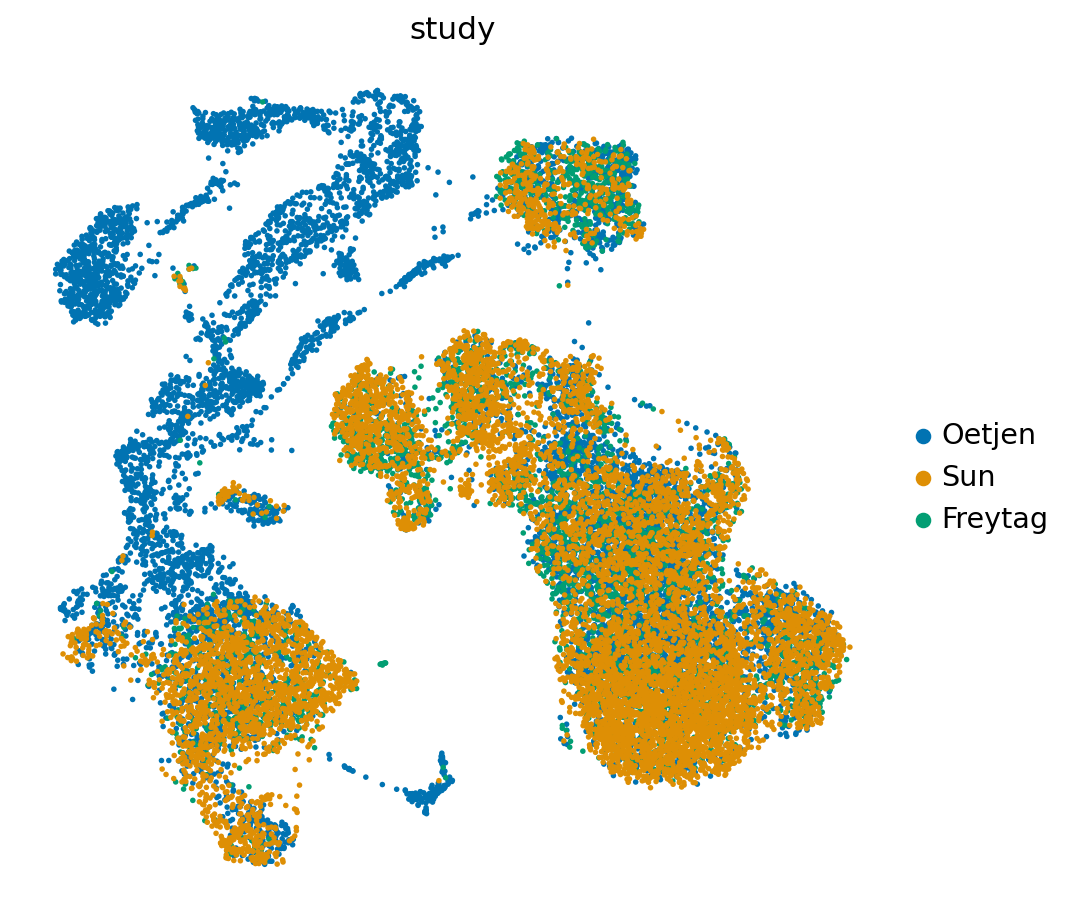

In [18]:
sc.pl.umap(reference_latent,
           color=['study'],
           frameon=False,
           wspace=0.6, s=25, 
           palette=sns.color_palette('colorblind', as_cmap=True)[:3],
#            save='study.pdf'
           )

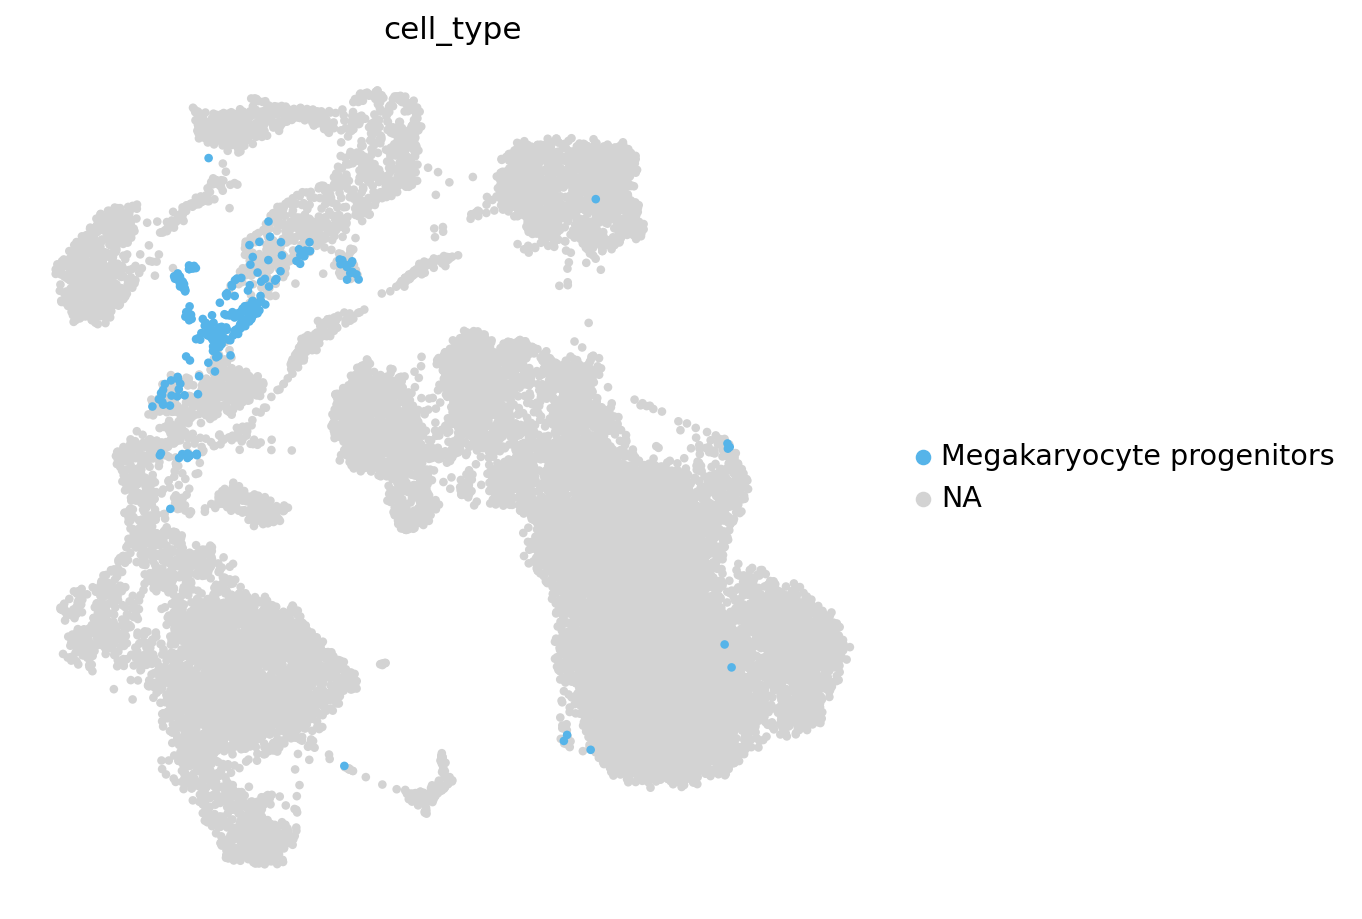

In [19]:
sc.pl.umap(reference_latent,
           color=['cell_type'], groups='Megakaryocyte progenitors',
           frameon=False,
           wspace=0.6, s=60, 
           palette=sns.color_palette('colorblind', as_cmap=True),
#            save='ref_cp.pdf'
           )

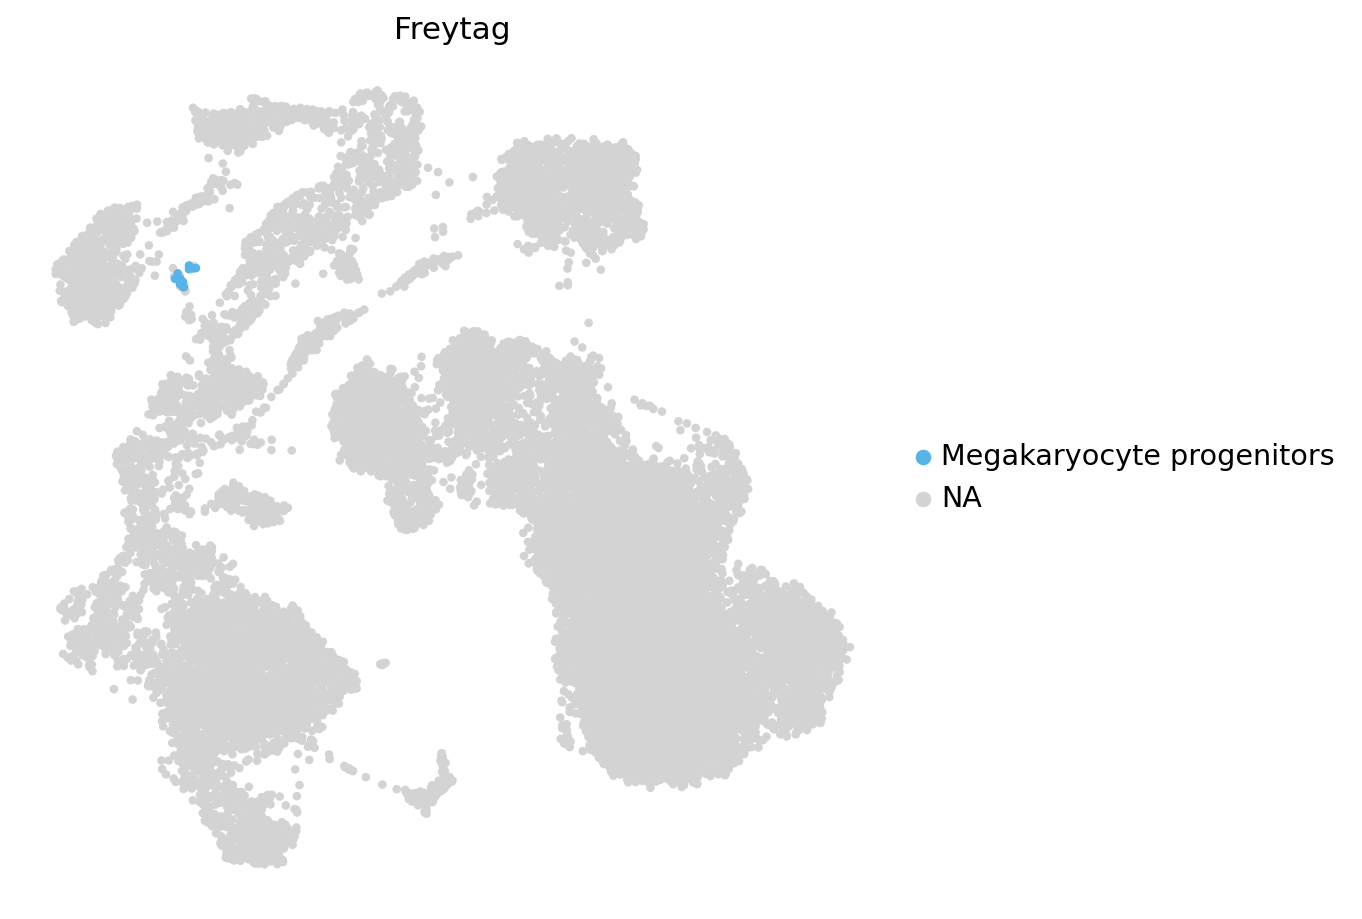

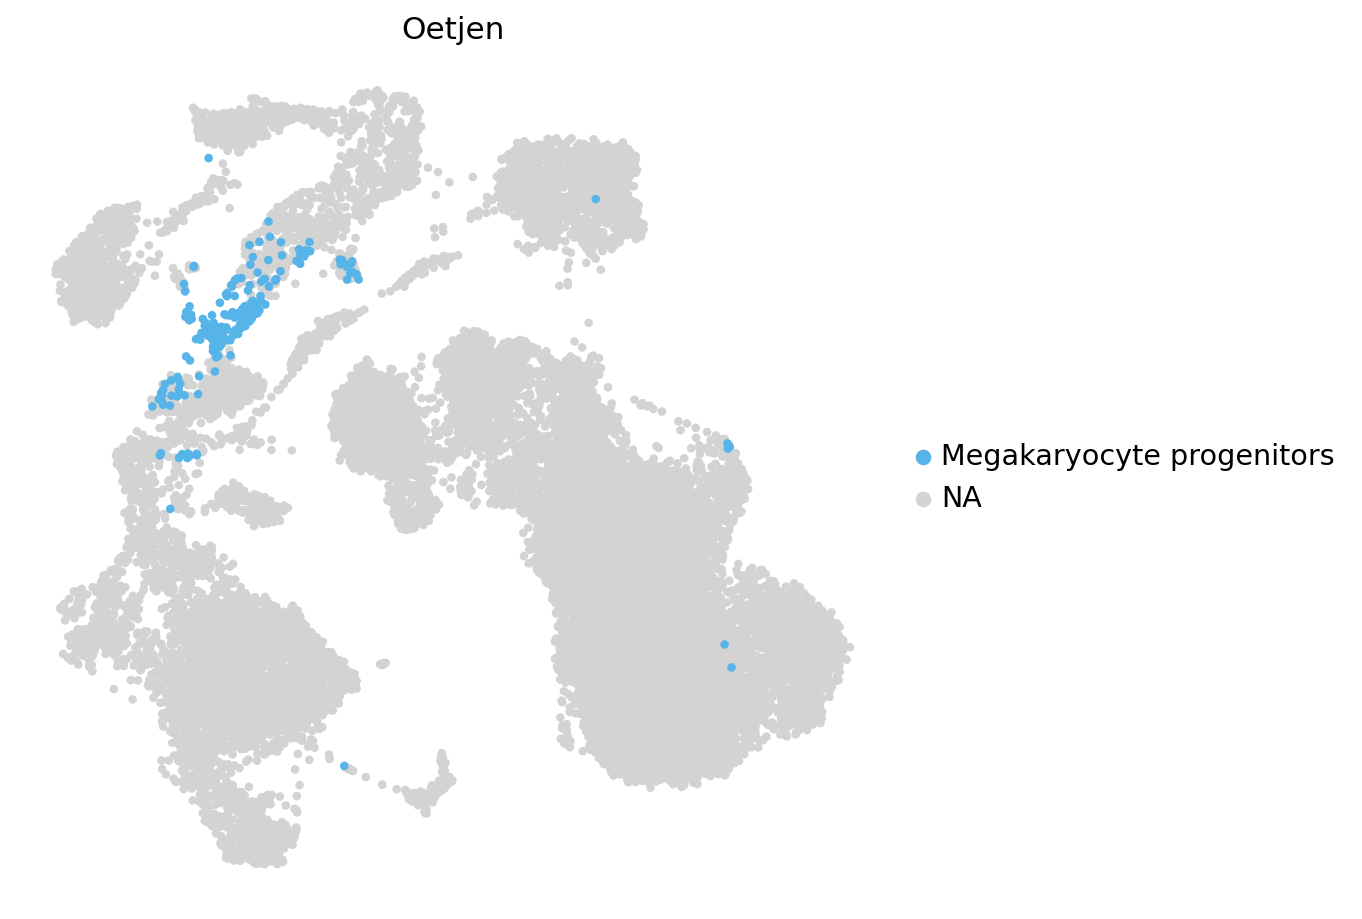

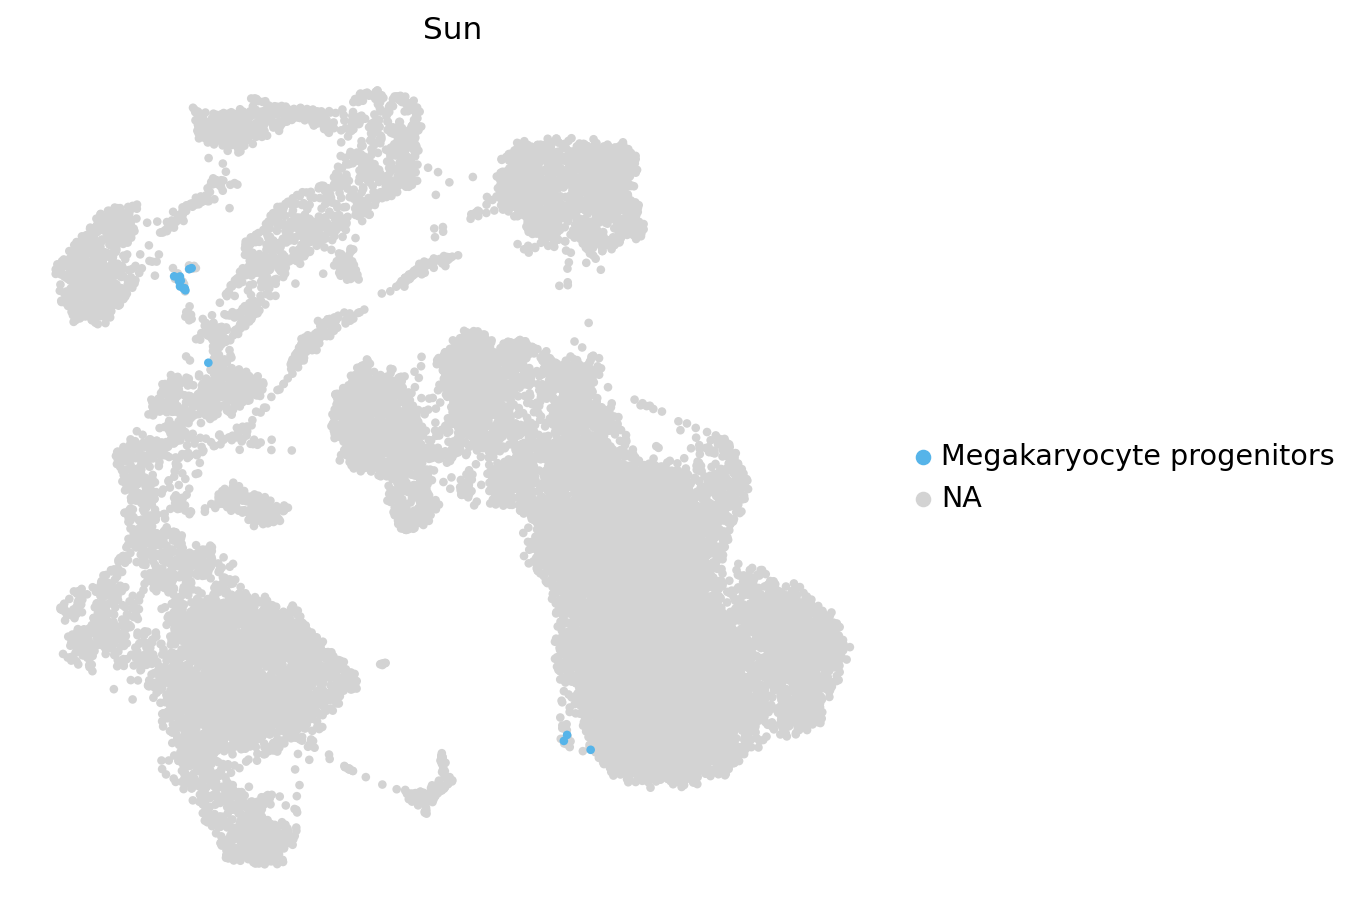

In [20]:
# We can also visualize the cell populations per dataset
for s in np.unique(reference_latent.obs.study):
    ref_s = cp.deepcopy(reference_latent)
    ref_s.obs.cell_type[reference_latent.obs.study != s] = np.nan

    sc.pl.umap(ref_s,
               color=['cell_type'], groups='Megakaryocyte progenitors',
               frameon=False,
               wspace=0.6, s=60, 
               palette=sns.color_palette('colorblind', as_cmap=True), title=s,
#                save=s+'.pdf'
               )

After pretraining the model and latent space can be saved for later use.

In [21]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)
reference_latent.write(ref_path + 'ref_latent.h5ad')

### Construct hierarchy for the reference using scHPL

We will relabel some cell types in the Sun and Oetjen dataset to simulate a different hierarchy.

In [22]:
reference_latent.obs['cell_type2'] = 0
reference_latent.obs['cell_type2'] = cp.deepcopy(reference_latent.obs['cell_type'].astype('str'))

In [23]:
idx_lymphoid = ((reference_latent.obs['study'] == 'Sun') & 
                np.isin(reference_latent.obs['cell_type'], 
                        ['CD20+ B cells', 
                         'CD4+ T cells', 'CD8+ T cells', 
                         'NK cells', 'NKT cells']))
reference_latent.obs['cell_type2'].iloc[idx_lymphoid] = 'Group 1'

/tmp/ipykernel_1323878/3509525136.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_latent.obs['cell_type2'].iloc[idx_lymphoid] = 'Group 1'


In [24]:
idx_myeloid = ((reference_latent.obs['study'] == 'Sun') & 
                np.isin(reference_latent.obs['cell_type'], 
                        ['CD14+ Monocytes', 'CD16+ Monocytes', 
                         'Monocyte-derived dendritic cells', 
                         'Plasmacytoid dendritic cells']))
reference_latent.obs['cell_type2'].iloc[idx_myeloid] = 'Group 2'

/tmp/ipykernel_1323878/1039500419.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_latent.obs['cell_type2'].iloc[idx_myeloid] = 'Group 2'


In [25]:
idx_T = ((reference_latent.obs['study'] == 'Oetjen') & 
                np.isin(reference_latent.obs['cell_type'], 
                        ['CD4+ T cells', 'CD8+ T cells']))
reference_latent.obs['cell_type2'].iloc[idx_T] = 'T cells'

/tmp/ipykernel_1323878/3709371003.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_latent.obs['cell_type2'].iloc[idx_T] = 'T cells'


In [26]:
idx_MC = ((reference_latent.obs['study'] == 'Oetjen') & 
                np.isin(reference_latent.obs['cell_type'], 
                        ['CD14+ Monocytes', 'CD16+ Monocytes']))
reference_latent.obs['cell_type2'].iloc[idx_MC] = 'Monocytes' 

/tmp/ipykernel_1323878/510301141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference_latent.obs['cell_type2'].iloc[idx_MC] = 'Monocytes'


Next, we have to concatenate all cell type labels with the study labels. This way, we ensure that the cell types of the different studies are seen as unique.

In [27]:
reference_latent.obs['celltype_batch'] = np.char.add(np.char.add(np.array(reference_latent.obs['cell_type2'], dtype= str), '-'),
                                             np.array(reference_latent.obs['study'], dtype=str))

Starting tree:


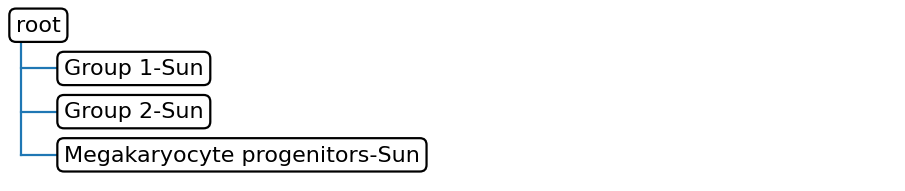


Adding dataset Oetjen to the tree

Updated tree:


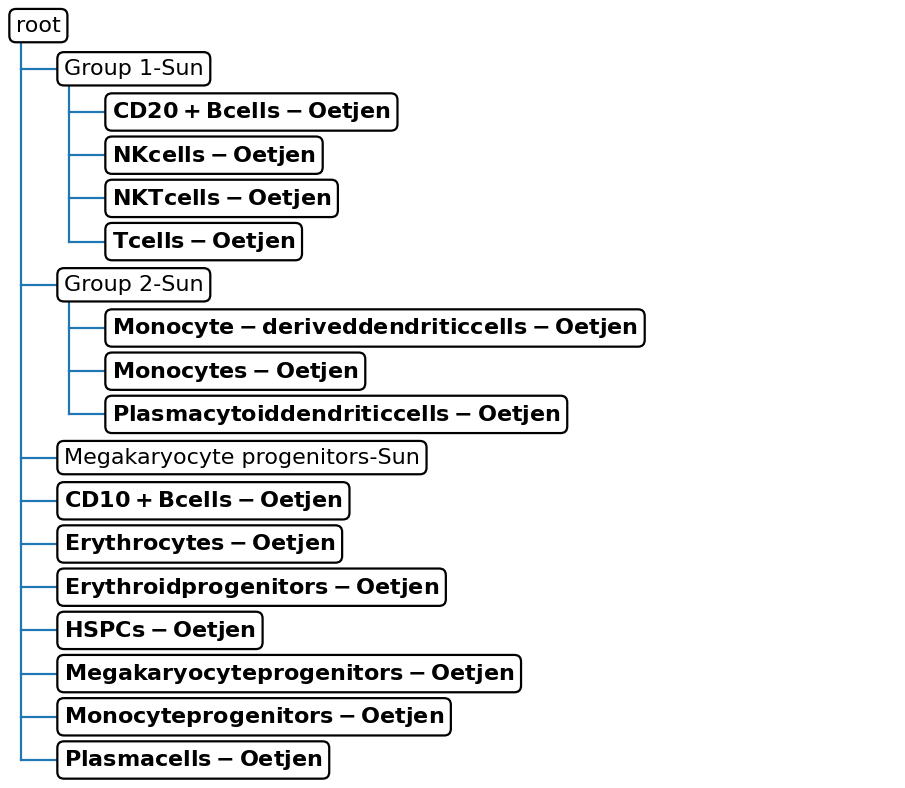


Adding dataset Freytag to the tree

Updated tree:


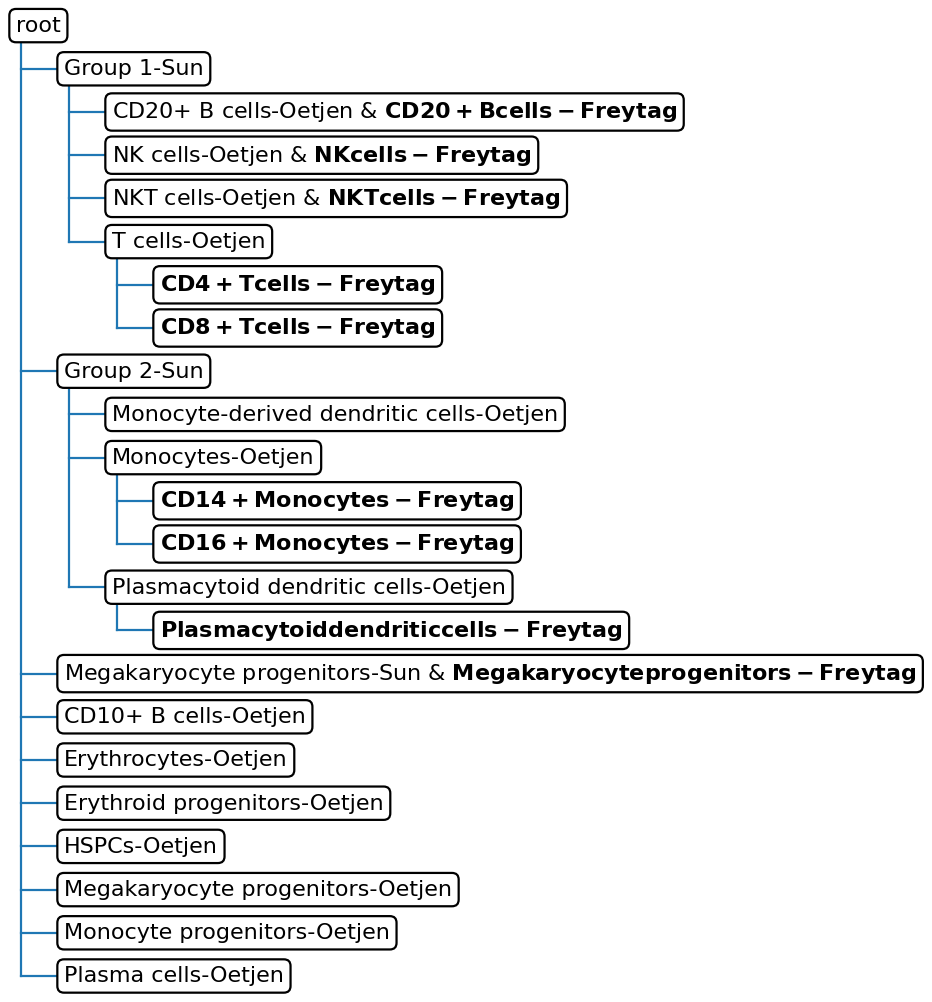

In [28]:
tree_ref, mp_ref = sca.classifiers.scHPL.learn_tree(data = reference_latent, 
                batch_key = 'study',
                batch_order = ['Sun', 'Oetjen', 'Freytag'],
                cell_type_key='celltype_batch',
                classifier = 'knn', dynamic_neighbors=True,
                dimred = False, print_conf= False)


### Visualizing marker genes for the MK progenitor populations (Fig. S2)

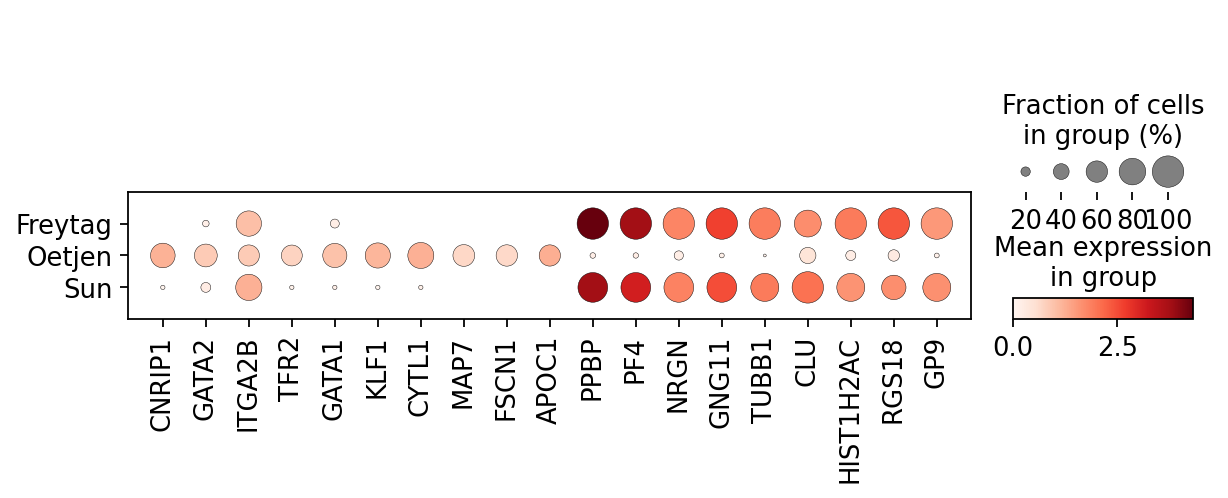

In [29]:
mk = source_adata[source_adata.obs.final_annotation == 'Megakaryocyte progenitors']

# Marker genes from Azimuth reference (PBMC and bone marrow)
# Marker genes early erythroid: 'CNRIP1','GATA2','ITGA2B','TFR2', 'GATA1','KLF1','CYTL1','MAP7','FSCN1','APOC1'
# Marker genes platelets: 'PPBP', 'PF4', 'NRGN', 'GNG11', 'TUBB1', 'CLU', 'HIST1H2AC', 'RGS18', 'GP9'

sc.pl.dotplot(mk, var_names=['CNRIP1','GATA2','ITGA2B','TFR2',
                             'GATA1','KLF1','CYTL1','MAP7','FSCN1','APOC1',
                             'PPBP', 'PF4', 'NRGN', 'GNG11', 
                             'TUBB1', 'CLU', 'HIST1H2AC', 'RGS18', 'GP9'], 
              groupby='study', log=True,
#               save='azimuth_platelet_early_ery.pdf'
             )

### Use pretrained reference model and apply surgery with a new query dataset to get a bigger reference atlas

Since the model requires the datasets to have the same genes we also filter the query dataset to have the same genes as the reference dataset.

In [30]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

We then can apply the model surgery with the new query dataset:

In [31]:
target_adata = target_adata.copy()

In [32]:
model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)

INFO     File ref_model_GPU/model.pt already downloaded                                      


In [33]:
model.train(max_epochs=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.90it/s, loss=976, v_num=1]


In [34]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs["final_annotation"].tolist()
query_latent.obs['batch'] = target_adata.obs["batch"].tolist()

And again we can save or upload the retrained model for later use or additional extensions.

In [35]:
surgery_path = 'surgery_model_GPU'
model.save(surgery_path, overwrite=True)
query_latent.write(surgery_path + '/query_latent.h5ad')

### Visualize latent representation of reference + query dataset

In [36]:
query_latent.obs['study'] = "10X"
query_latent.obs['cell_type2'] = query_latent.obs['cell_type']
full_latent  = reference_latent.concatenate(query_latent, batch_key="ref_query")


In [37]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

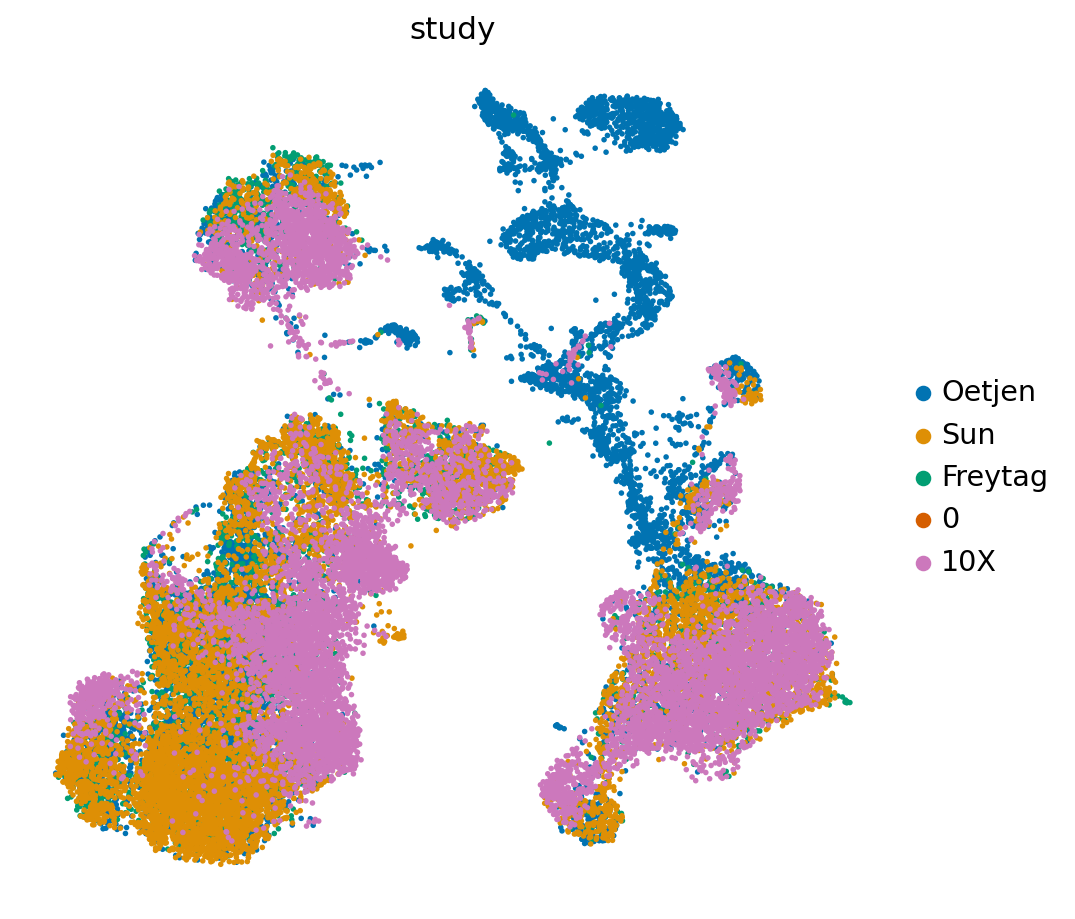

In [38]:
full_latent.obs['study'] = full_latent.obs['study'].astype('category')
full_latent.obs['study'].cat.add_categories(['0'], inplace=True)
full_latent.obs['study'].cat.reorder_categories(['Oetjen', 'Sun', 'Freytag', '0', '10X'], inplace=True)

sc.pl.umap(full_latent,
           color=['study'],
           frameon=False,
           wspace=0.6, s=25, 
           palette=sns.color_palette('colorblind', as_cmap=True)[:5],
#            save='study_query.pdf'
           )

In [39]:
full_latent.obs['ct_low'] = 0

idx = ((full_latent.obs.cell_type == 'CD4+ T cells') | 
       (full_latent.obs.cell_type == 'CD8+ T cells'))
full_latent.obs['ct_low'][idx] = 'T cells'

idx = ((full_latent.obs.cell_type == 'CD10+ B cells') | 
       (full_latent.obs.cell_type == 'CD20+ B cells'))
full_latent.obs['ct_low'][idx] = 'B cells'

idx = ((full_latent.obs.cell_type == 'CD14+ Monocytes') | 
       (full_latent.obs.cell_type == 'CD16+ Monocytes') |
       (full_latent.obs.cell_type == 'Monocyte progenitors'))
full_latent.obs['ct_low'][idx] = 'Monocytes'

idx = ((full_latent.obs.cell_type == 'Erythrocytes') | 
       (full_latent.obs.cell_type == 'Erythroid progenitors'))
full_latent.obs['ct_low'][idx] = 'Erythrocytes'

idx = ((full_latent.obs.cell_type == 'Monocyte-derived dendritic cells') | 
       (full_latent.obs.cell_type == 'Plasmacytoid dendritic cells'))
full_latent.obs['ct_low'][idx] = 'Dendritic cells'

idx = full_latent.obs.cell_type == 'HSPCs'
full_latent.obs['ct_low'][idx] = 'HSPCs'

idx = full_latent.obs.cell_type == 'Megakaryocyte progenitors'
full_latent.obs['ct_low'][idx] = 'Megakaryocyte progenitors'

idx = full_latent.obs.cell_type == 'NK cells'
full_latent.obs['ct_low'][idx] = 'NK cells'

idx = full_latent.obs.cell_type == 'NKT cells'
full_latent.obs['ct_low'][idx] = 'NKT cells'

idx = full_latent.obs.cell_type == 'Plasma cells'
full_latent.obs['ct_low'][idx] = 'Plasma cells'


/tmp/ipykernel_1323878/1546695568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_latent.obs['ct_low'][idx] = 'T cells'


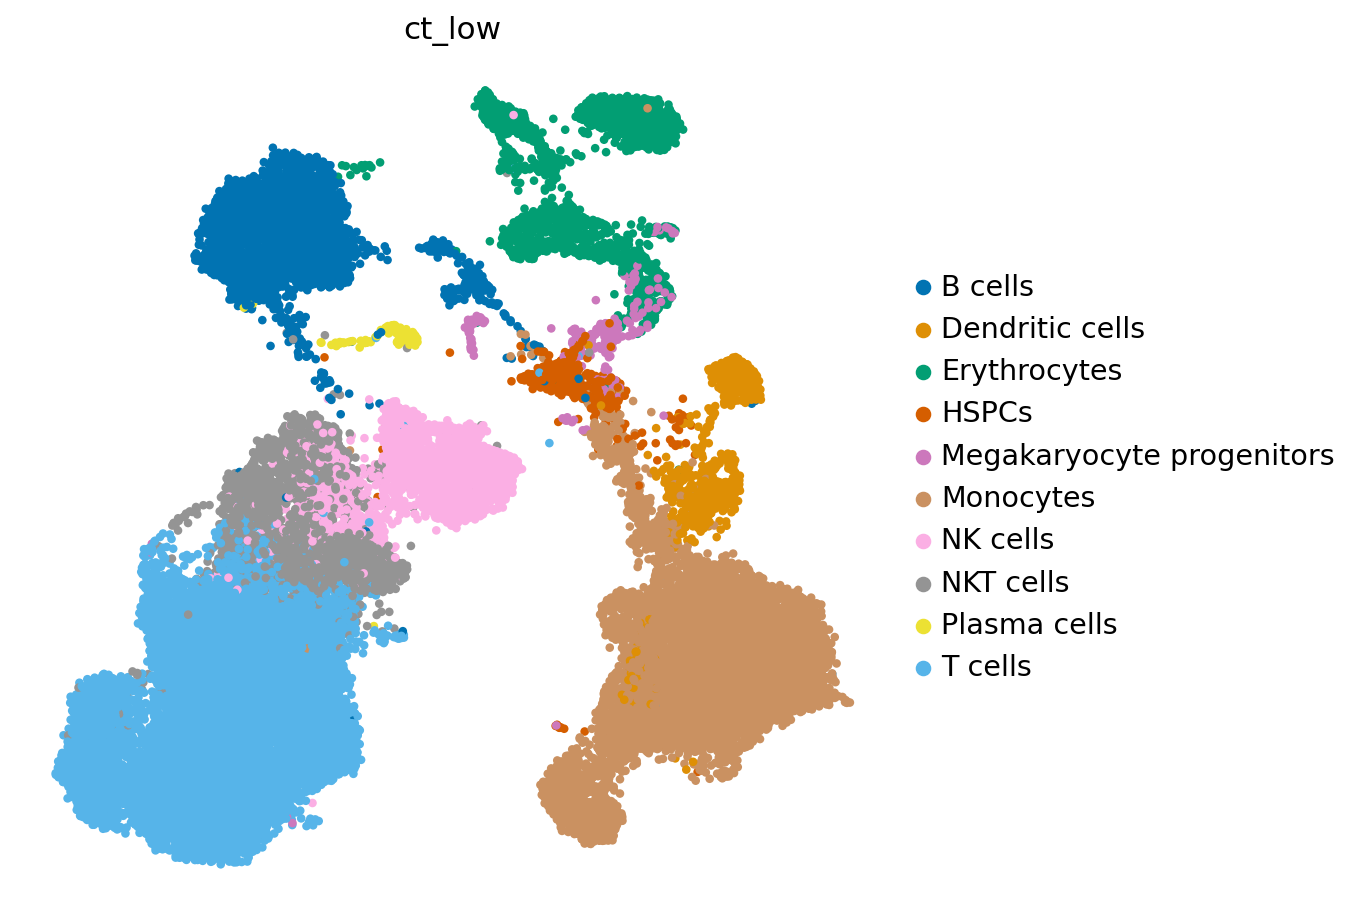

In [40]:
sc.pl.umap(full_latent,
           color=['ct_low'], 
           frameon=False,
           wspace=0.6, s=60, 
           palette=sns.color_palette('colorblind', as_cmap=True),
#            save='cp_query.pdf'
           )


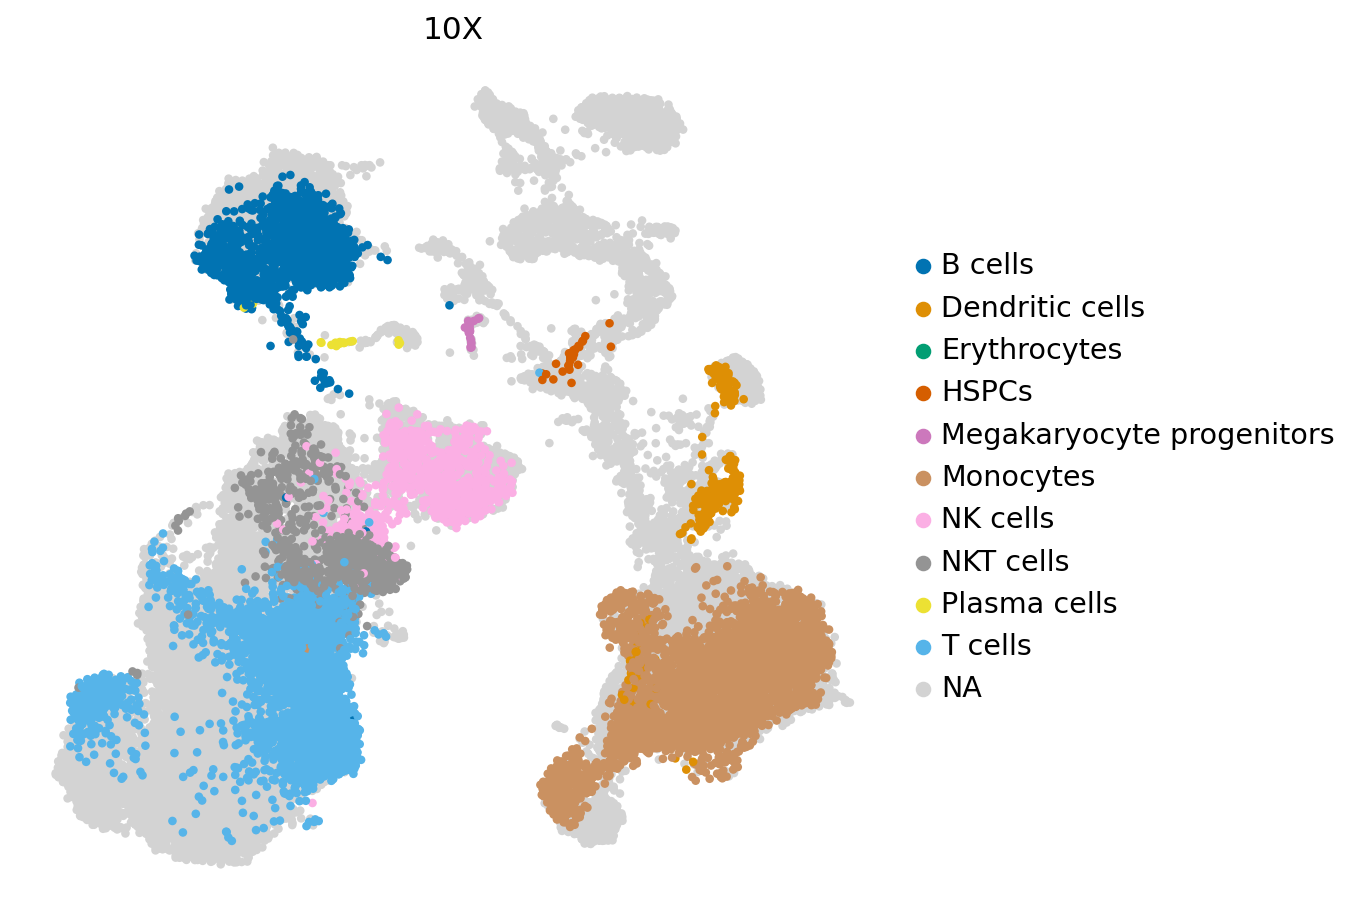

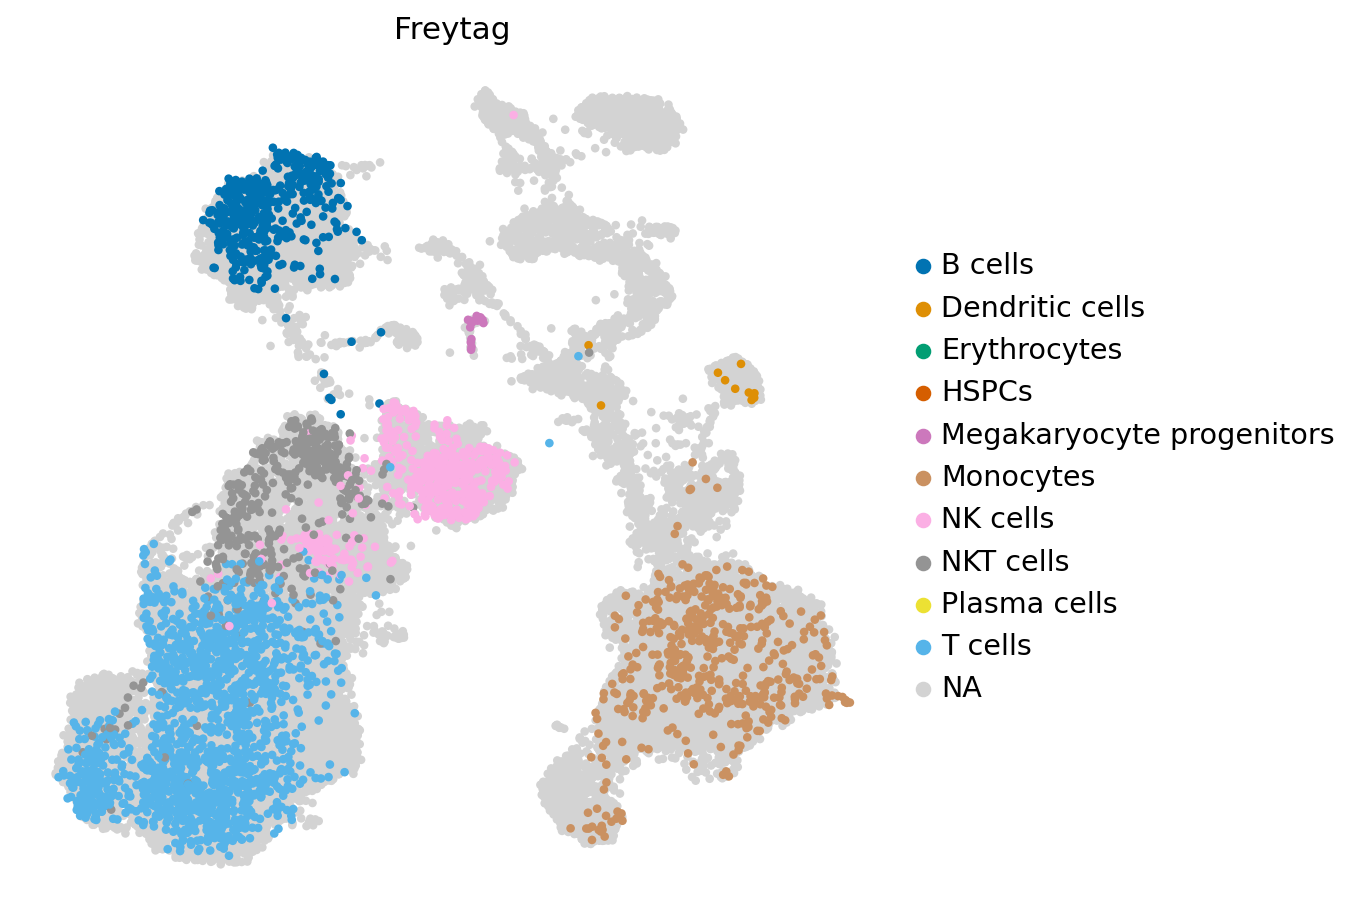

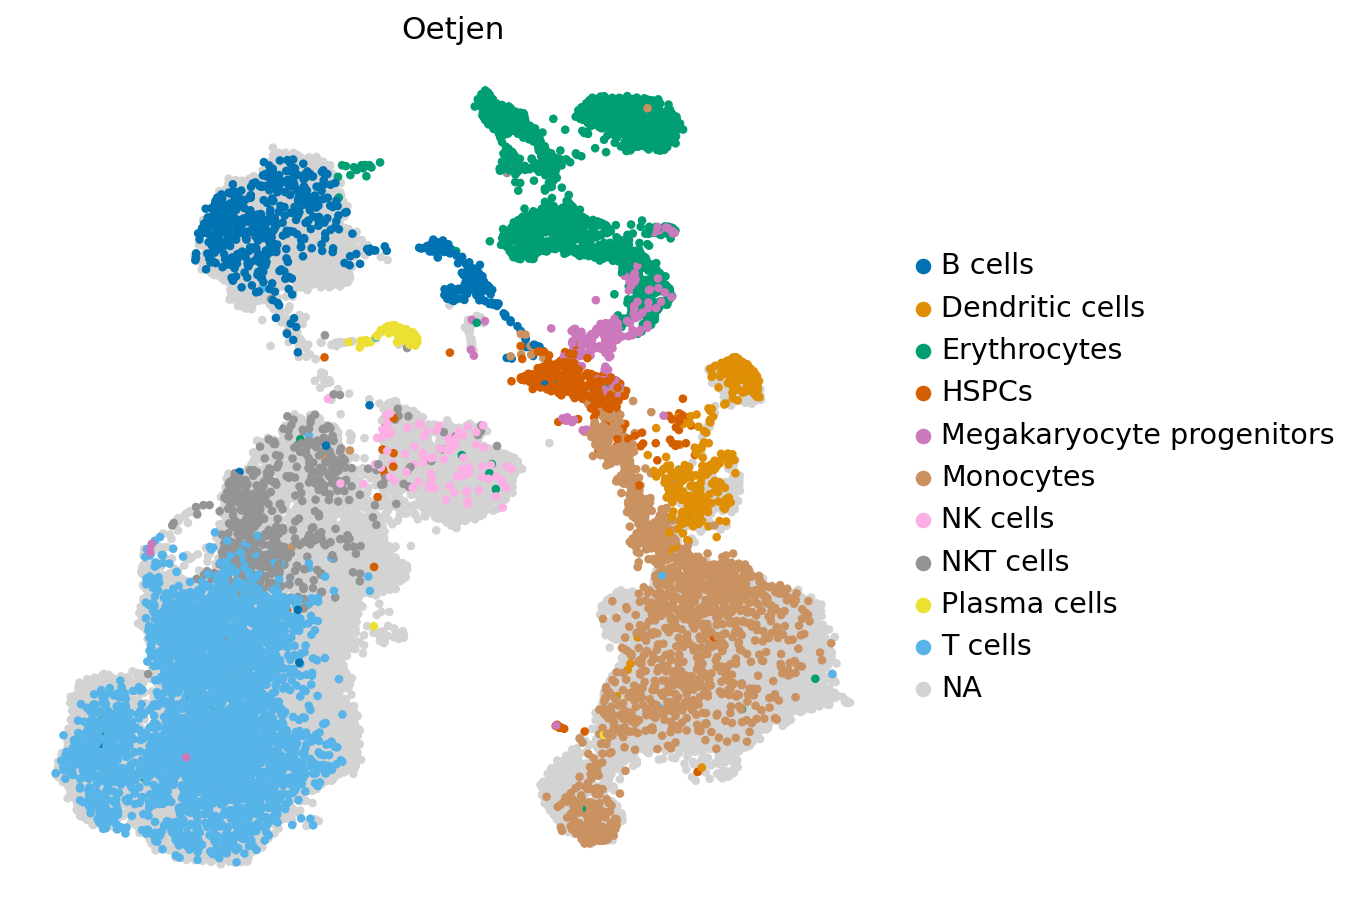

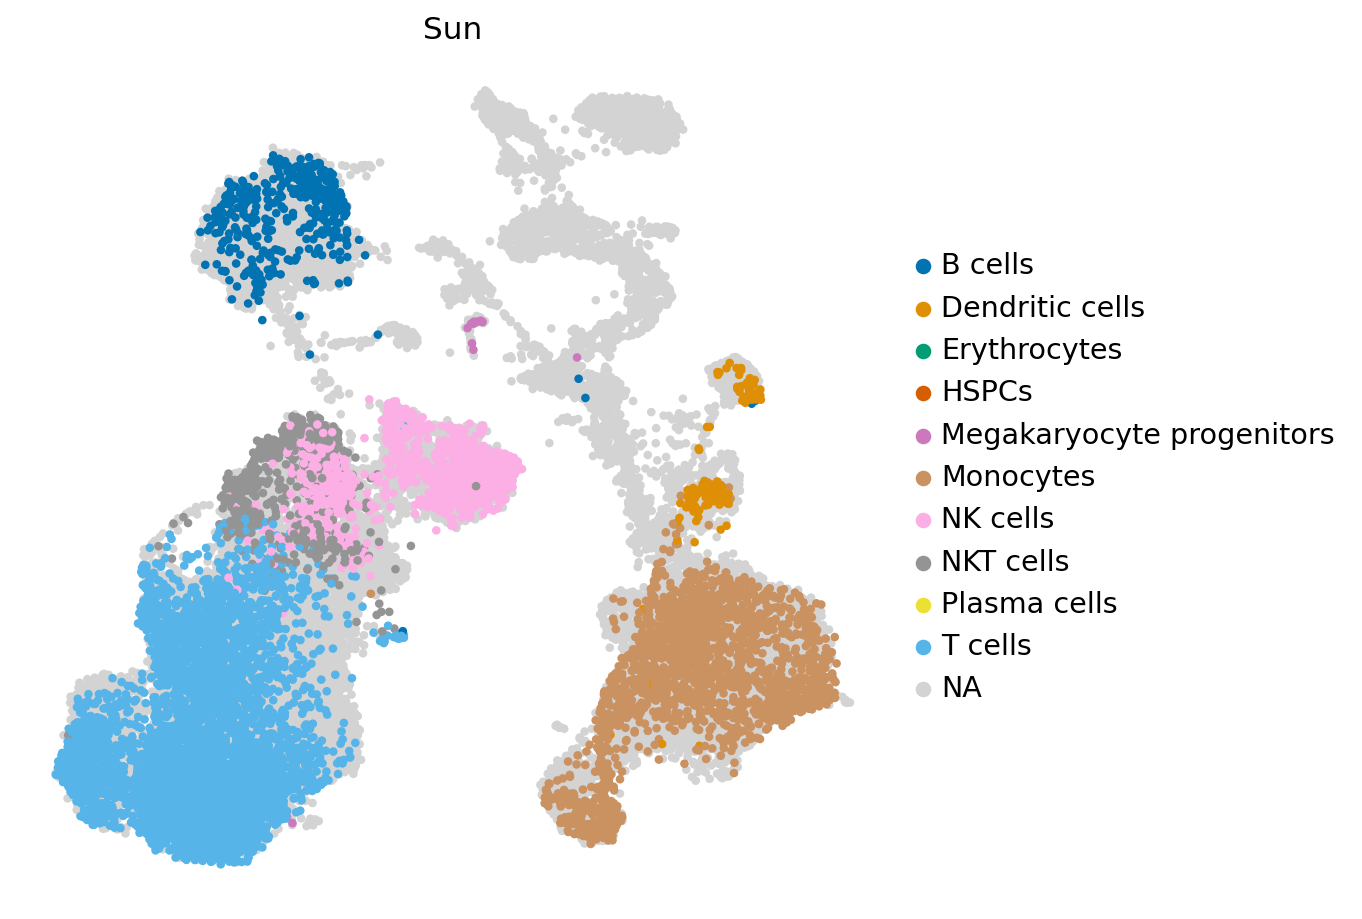

In [41]:
for s in np.unique(full_latent.obs.study):
    ref_s = cp.deepcopy(full_latent)
    ref_s.obs.ct_low[full_latent.obs.study != s] = np.nan

    sc.pl.umap(ref_s,
               color=['ct_low'], 
               frameon=False,
               wspace=0.6, s=60, 
               palette=sns.color_palette('colorblind', as_cmap=True), title=s,
#                save=s+'_query.pdf'
               )


### Update hierarchy with query dataset

In [42]:
# Again make the labels unique
full_latent.obs['celltype_batch'] = np.char.add(np.char.add(np.array(full_latent.obs['cell_type2'], dtype= str), '-'),
                                             np.array(full_latent.obs['study'], dtype=str))

We want to store the original reference to make prediction later on, so we use deepcopy to ensure this copy is not updated.

In [43]:
tree_ref_ = cp.deepcopy(tree_ref)

Starting tree:


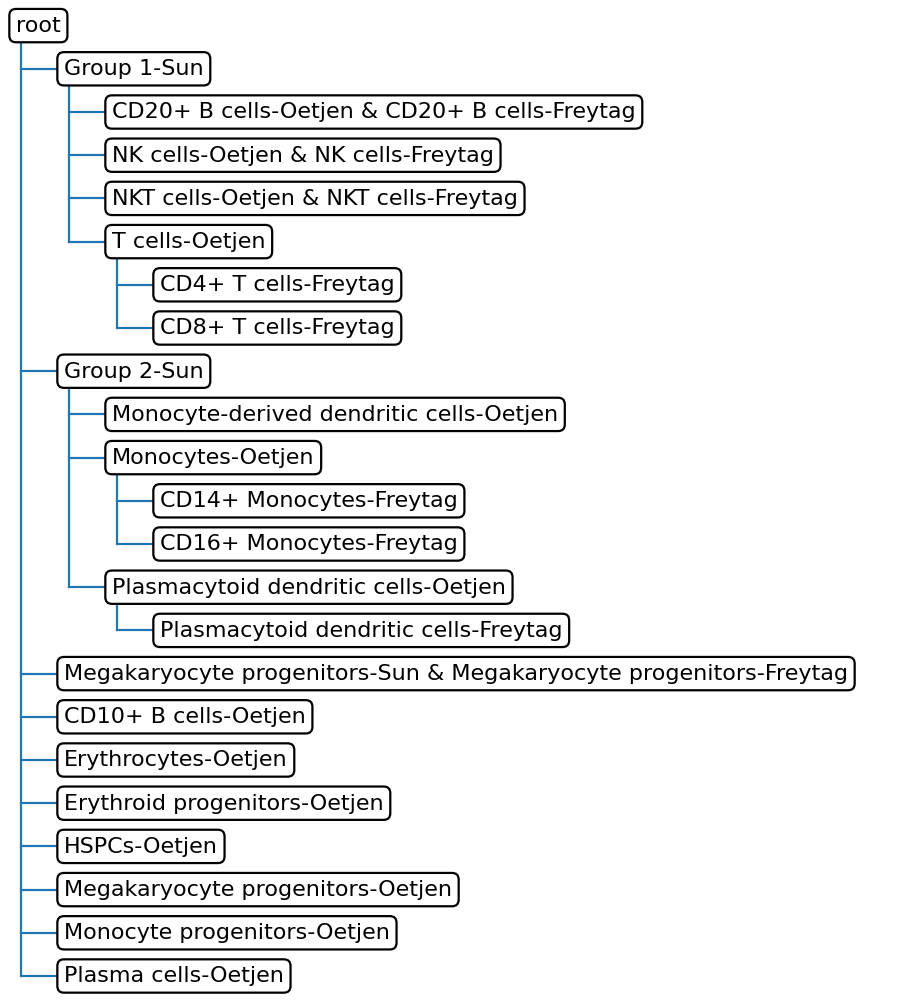


Adding dataset 10X to the tree

Updated tree:


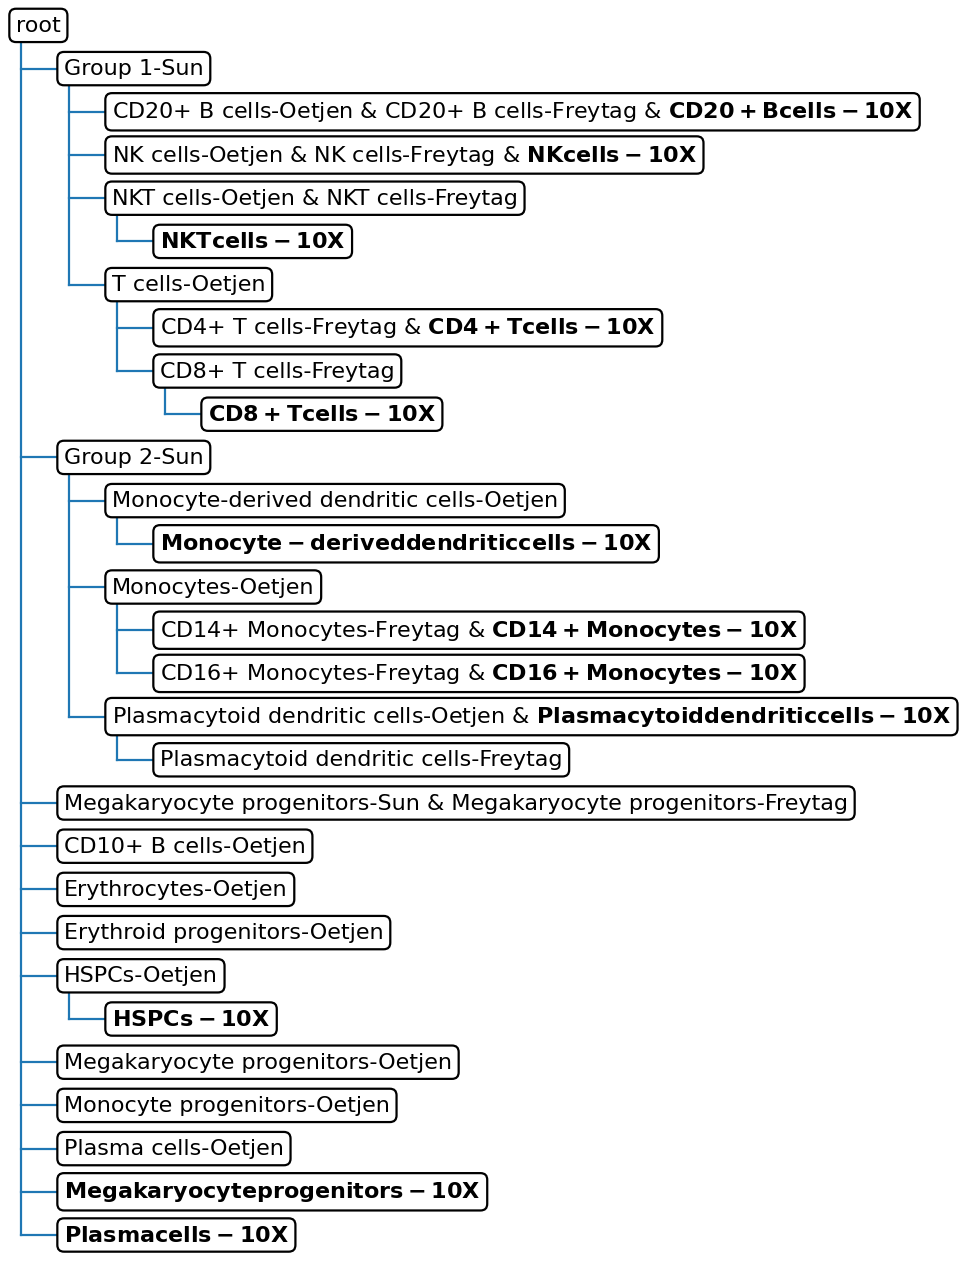

In [44]:
tree_rq, mp_rq = sca.classifiers.scHPL.learn_tree(data = full_latent, batch_key = 'study',
                 batch_order = ['10X'],
                 batch_added = ['Oetjen', 'Freytag', 'Sun'],
                 cell_type_key='celltype_batch',
                 tree = tree_ref, retrain = False,
                classifier = 'knn',
                dimred = False)

### Predict labels 10X

In [45]:
y_pred = sca.classifiers.scHPL.predict.predict_labels(query_latent.X,
                                                   tree = tree_ref_)

In [46]:
y_true = query_latent.obs['cell_type'].astype(str)
y_true[y_true == 'Monocyte-derived dendritic cells'] =  'Monocyte derived dendritic cells'
y_pred[y_pred == 'Monocyte-derived dendritic cells-Oetjen'] =  'Monocyte derived dendritic cells-Oetjen'
y_pred[y_pred == 'Rejected (RE)'] =  'root'
y_pred[y_pred == 'Rejection (dist)'] =  'root'
y_pred = pd.DataFrame(y_pred)[0].str.split('-', expand=True)[0]


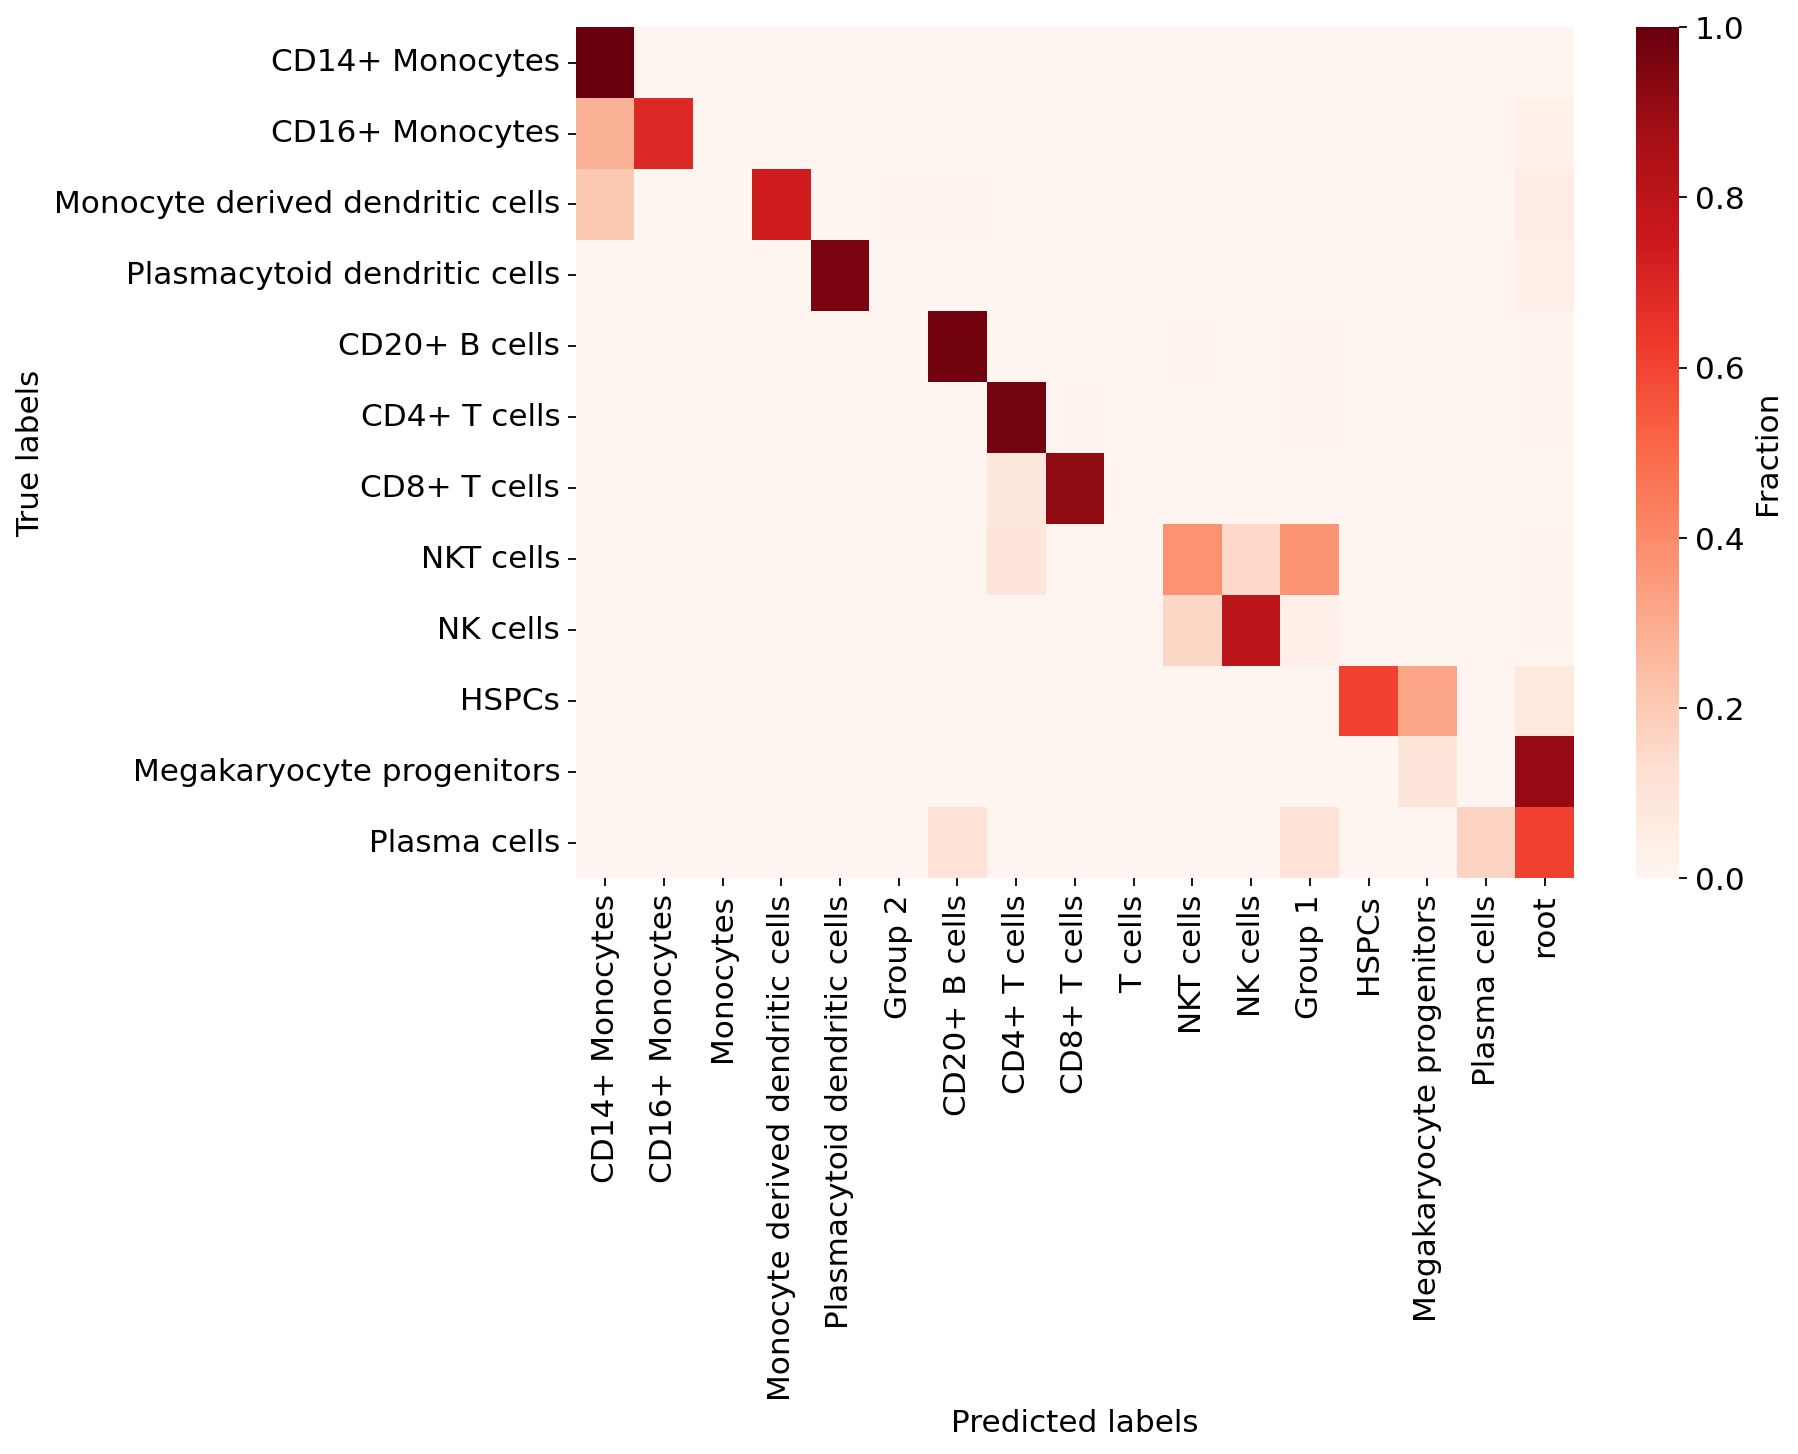

In [47]:
order_rows = ['CD14+ Monocytes', 'CD16+ Monocytes', 
              'Monocyte derived dendritic cells', 'Plasmacytoid dendritic cells',
              'CD20+ B cells',
              'CD4+ T cells', 'CD8+ T cells', 
              'NKT cells', 'NK cells', 
              'HSPCs', 'Megakaryocyte progenitors', 
              'Plasma cells',
             ]

order_cols = ['CD14+ Monocytes', 'CD16+ Monocytes', 'Monocytes',
              'Monocyte derived dendritic cells', 'Plasmacytoid dendritic cells', 
              'Group 2',
              'CD20+ B cells', 
              'CD4+ T cells', 'CD8+ T cells', 'T cells', 
              'NKT cells', 'NK cells', 'Group 1',
              'HSPCs', 'Megakaryocyte progenitors',
              'Plasma cells', 'root']

sca.classifiers.scHPL.evaluate.heatmap(y_true, y_pred,
                                      shape=(10,7), order_rows=order_rows,
                                      order_cols=order_cols)
plt.show()
              

Compare to Azimuth predictions. Prediction can be downloaded from Zenodo as well.

In [48]:
pred_az = pd.read_csv('azimuth_predictions.csv', index_col=0)
np.unique(pred_az['predicted.hierarchy'])

array(['CD14+ Monocytes', 'CD20+ B cells', 'CD4+ T cells', 'CD8+ T cells',
       'HSPCs', 'Lymphoid', 'Megakaryocyte progenitors',
       'Monocyte-derived dendritic cells', 'Monocytes', 'Myeloid',
       'NK cells', 'NKT cells', 'Plasmacytoid dendritic cells', 'T cells'],
      dtype=object)

In [49]:
pred_az['predicted.hierarchy'][pred_az['predicted.hierarchy'] == 'Monocyte-derived dendritic cells'] = 'Monocyte derived dendritic cells'
pred_az['predicted.hierarchy'][pred_az['predicted.hierarchy'] == 'Lymphoid'] = 'Group 1'
pred_az['predicted.hierarchy'][pred_az['predicted.hierarchy'] == 'Myeloid'] = 'Group 2'


/tmp/ipykernel_1323878/2169440920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_az['predicted.hierarchy'][pred_az['predicted.hierarchy'] == 'Monocyte-derived dendritic cells'] = 'Monocyte derived dendritic cells'
/tmp/ipykernel_1323878/2169440920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_az['predicted.hierarchy'][pred_az['predicted.hierarchy'] == 'Lymphoid'] = 'Group 1'
/tmp/ipykernel_1323878/2169440920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

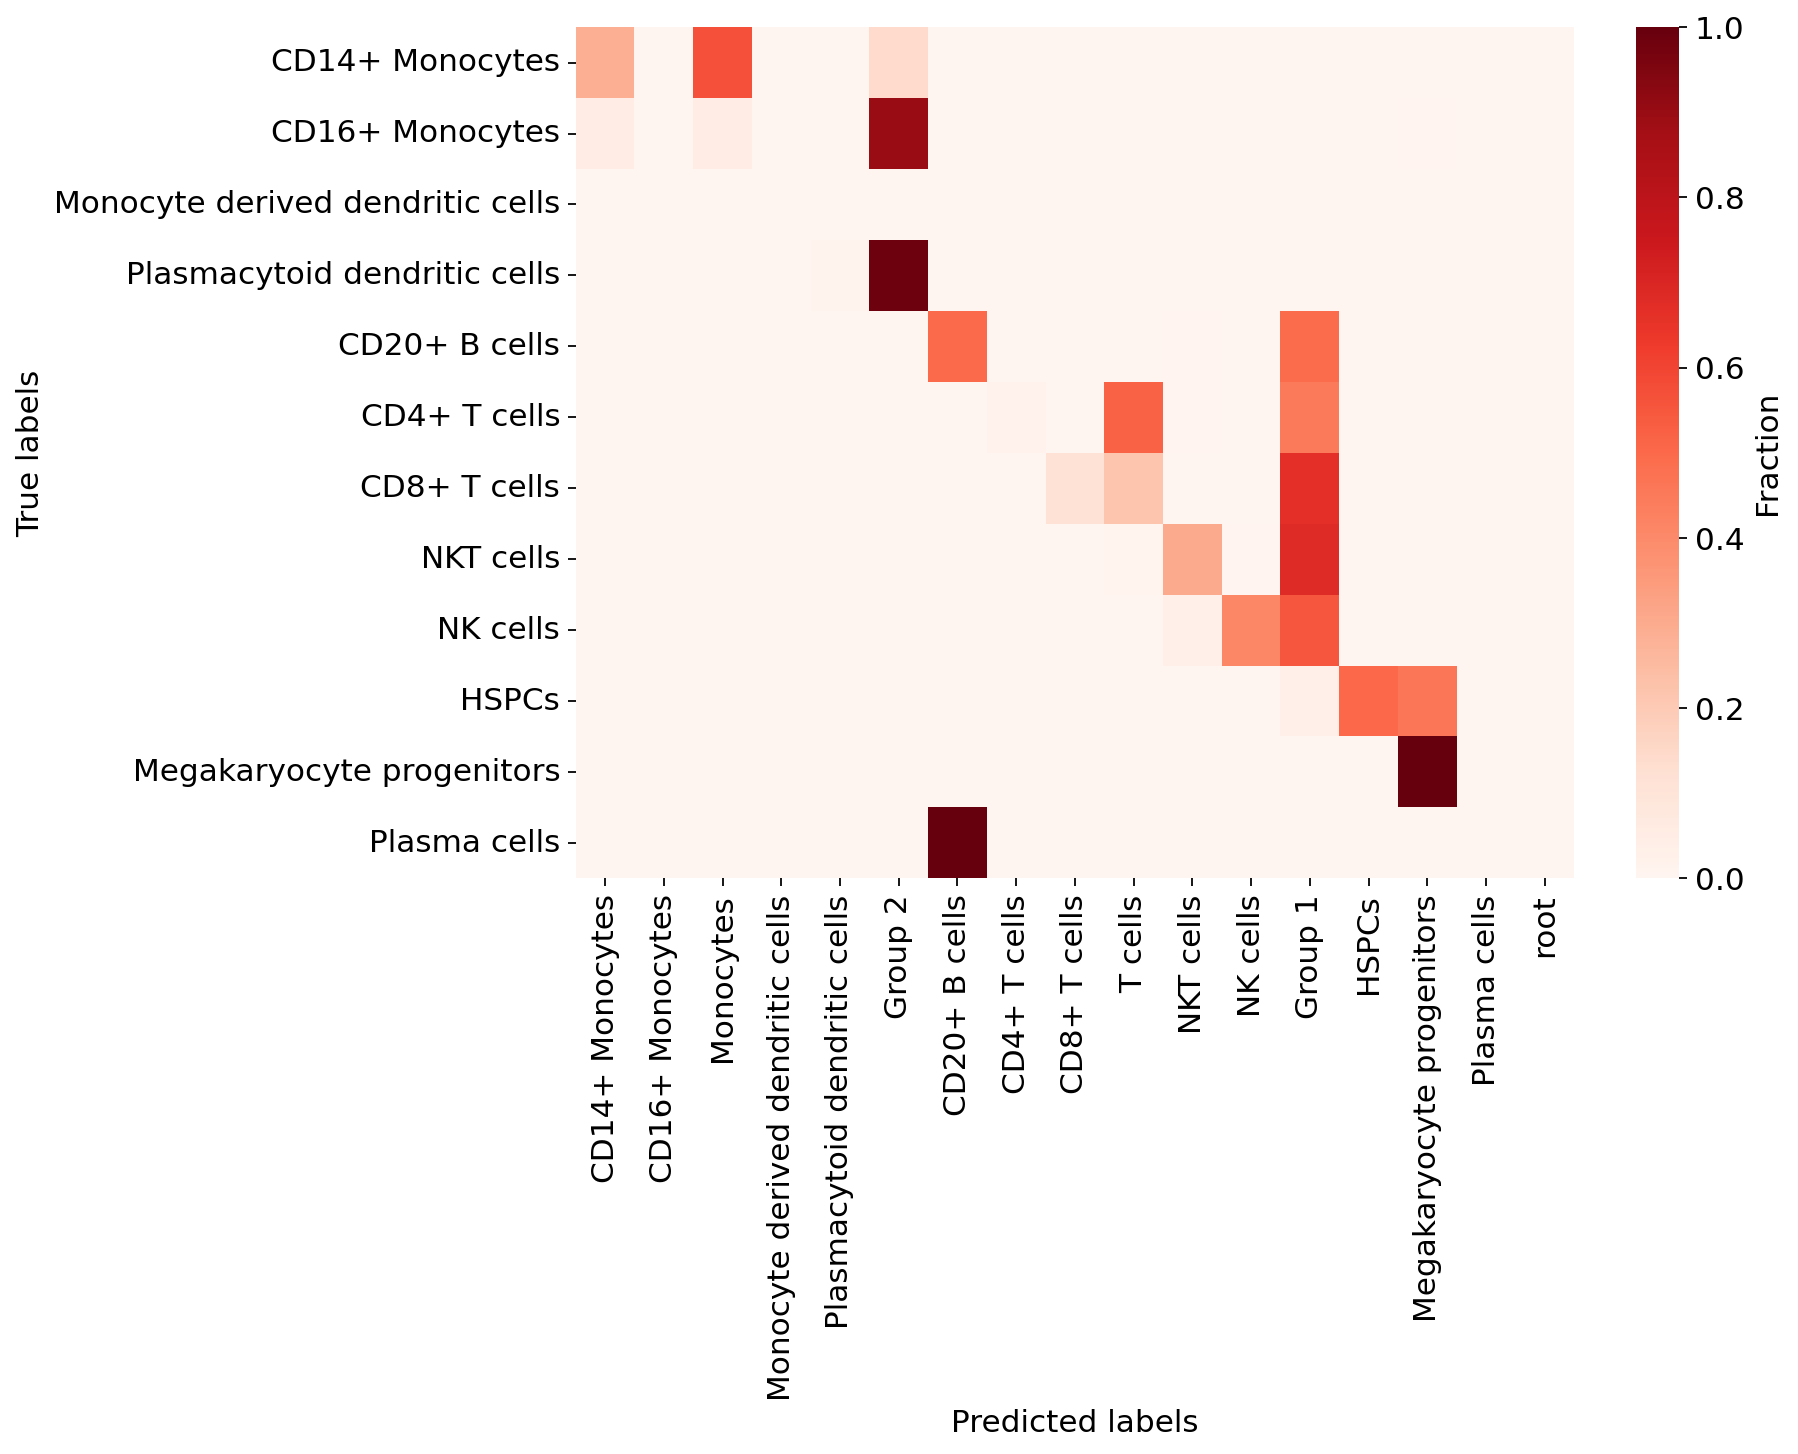

In [50]:
sca.classifiers.scHPL.evaluate.heatmap(query_latent.obs['cell_type'], pred_az['predicted.hierarchy'],
                                      shape=(10,7), order_rows=order_rows,
                                      order_cols=order_cols)
plt.show()

In [53]:
from sklearn.metrics import f1_score

F1_hier = pd.DataFrame(np.zeros((len(order_rows),2)), index=order_rows, columns=['treeArches', 'Azimuth'])

F1_hier['treeArches'] = f1_score(y_true, y_pred, average=None, labels=order_rows)
F1_hier['Azimuth'] = f1_score(y_true, pred_az['predicted.hierarchy'], average=None, labels=order_rows)


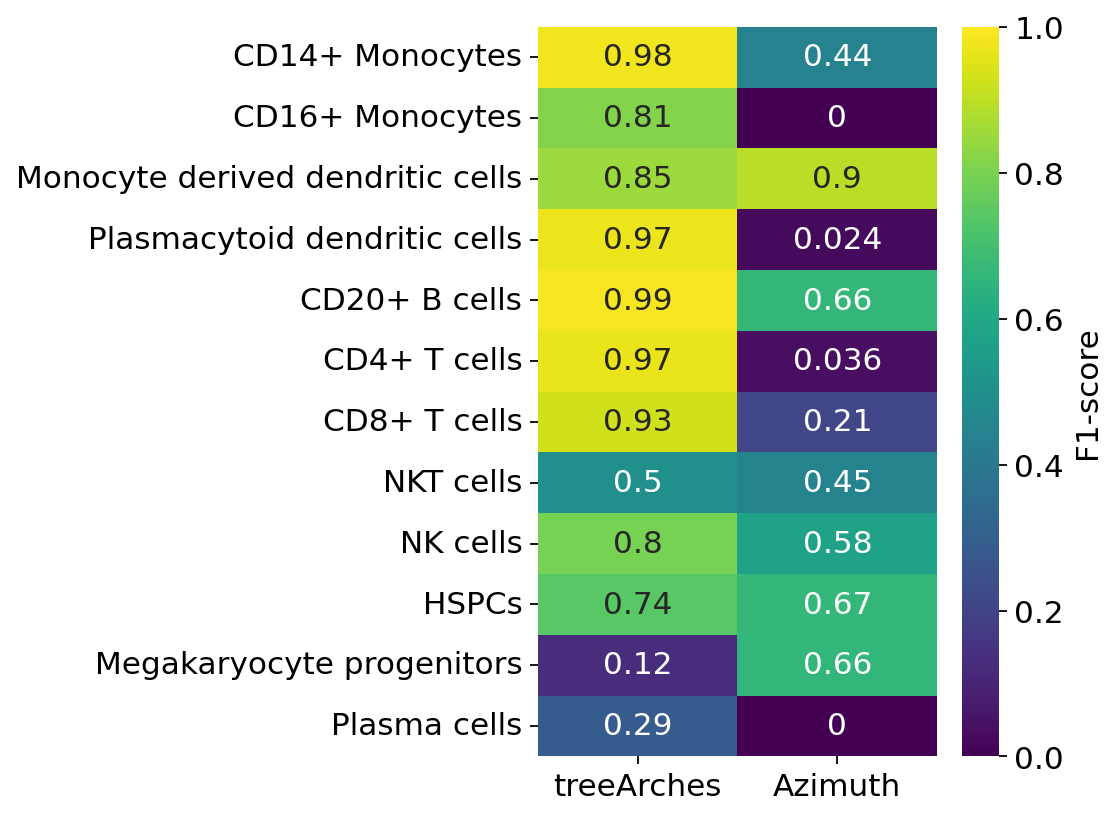

In [54]:
plt.figure(figsize=(4,6))
sns.heatmap(F1_hier,  vmin = 0, vmax = 1, 
                cbar_kws={'label': 'F1-score'}, cmap='viridis', annot=True)
plt.show()

### Train 'flat' classifier scHPL

In [55]:
def _construct_tree(tree, labels):
    '''
    Construct a flat tree.
    '''
    
    unique_labels = np.unique(labels)
    
    for ul in unique_labels:
        newnode = TreeNode([ul])
        tree[0].add_descendant(newnode)
        
    return tree

In [56]:
from scHPL.utils import TreeNode, create_tree, print_tree
tree_flat = create_tree('root')
tree_flat = _construct_tree(tree_flat, reference_latent.obs['cell_type'])

In [57]:
from scHPL.train import train_tree
tree_flat = train_tree(reference_latent.X, reference_latent.obs['cell_type'].astype(str), tree_flat, 
                       classifier='knn', dimred=False, dynamic_neighbors='True')

In [58]:
y_pred_flat = sca.classifiers.scHPL.predict.predict_labels(query_latent.X,
                                                   tree = tree_flat)

In [60]:
y_pred_flat[y_pred_flat == 'Rejected (RE)'] =  'root'
y_pred_flat[y_pred_flat == 'Rejection (dist)'] =  'root'
y_pred_flat[y_pred_flat == 'Monocyte-derived dendritic cells'] =  'Monocyte derived dendritic cells'

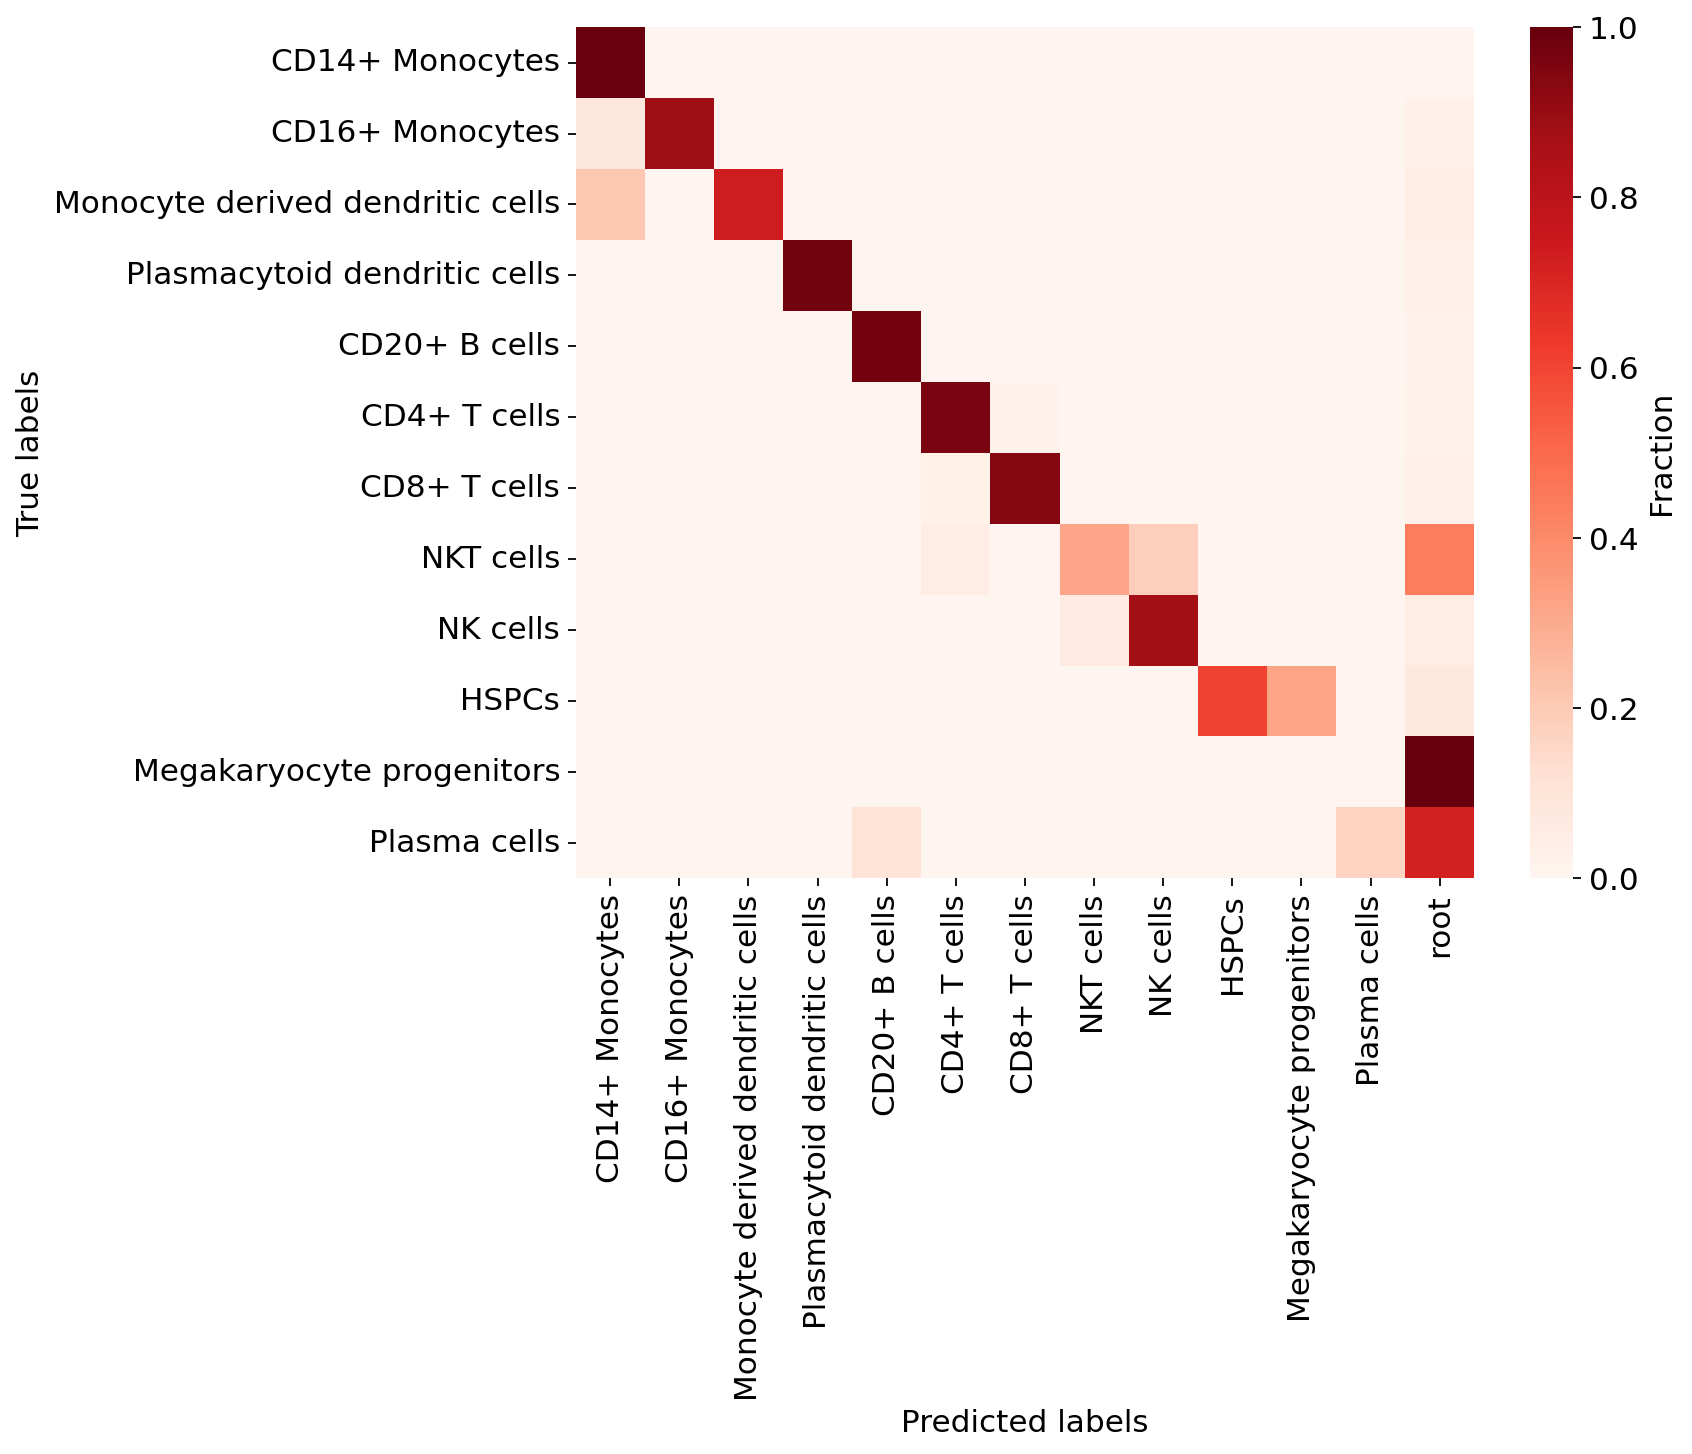

In [61]:
order_cols2 = ['CD14+ Monocytes', 'CD16+ Monocytes',
              'Monocyte derived dendritic cells', 'Plasmacytoid dendritic cells', 
              'CD20+ B cells',
              'CD4+ T cells', 'CD8+ T cells', 
              'NKT cells', 'NK cells', 
              'HSPCs', 'Megakaryocyte progenitors', 
              'Plasma cells', 'root']
       
sca.classifiers.scHPL.evaluate.heatmap(y_true, y_pred_flat,
                                      shape=(9,7), order_rows=order_rows,
                                      order_cols=order_cols2)
plt.show()

Compare to linear SVM

In [62]:
tree_flat_svm = create_tree('root')
tree_flat_svm = _construct_tree(tree_flat_svm, reference_latent.obs['cell_type'])

In [63]:
tree_flat_svm = train_tree(reference_latent.X, reference_latent.obs['cell_type'].astype(str), tree_flat_svm, 
                       classifier='svm', dimred=False, dynamic_neighbors='True')

In [64]:
y_pred_flat_svm = sca.classifiers.scHPL.predict.predict_labels(query_latent.X,
                                                   tree = tree_flat_svm)

In [65]:
y_pred_flat_svm[y_pred_flat_svm == 'Rejected (RE)'] =  'root'
y_pred_flat_svm[y_pred_flat_svm == 'Rejection (dist)'] =  'root'
y_pred_flat_svm[y_pred_flat_svm == 'Monocyte-derived dendritic cells'] =  'Monocyte derived dendritic cells'

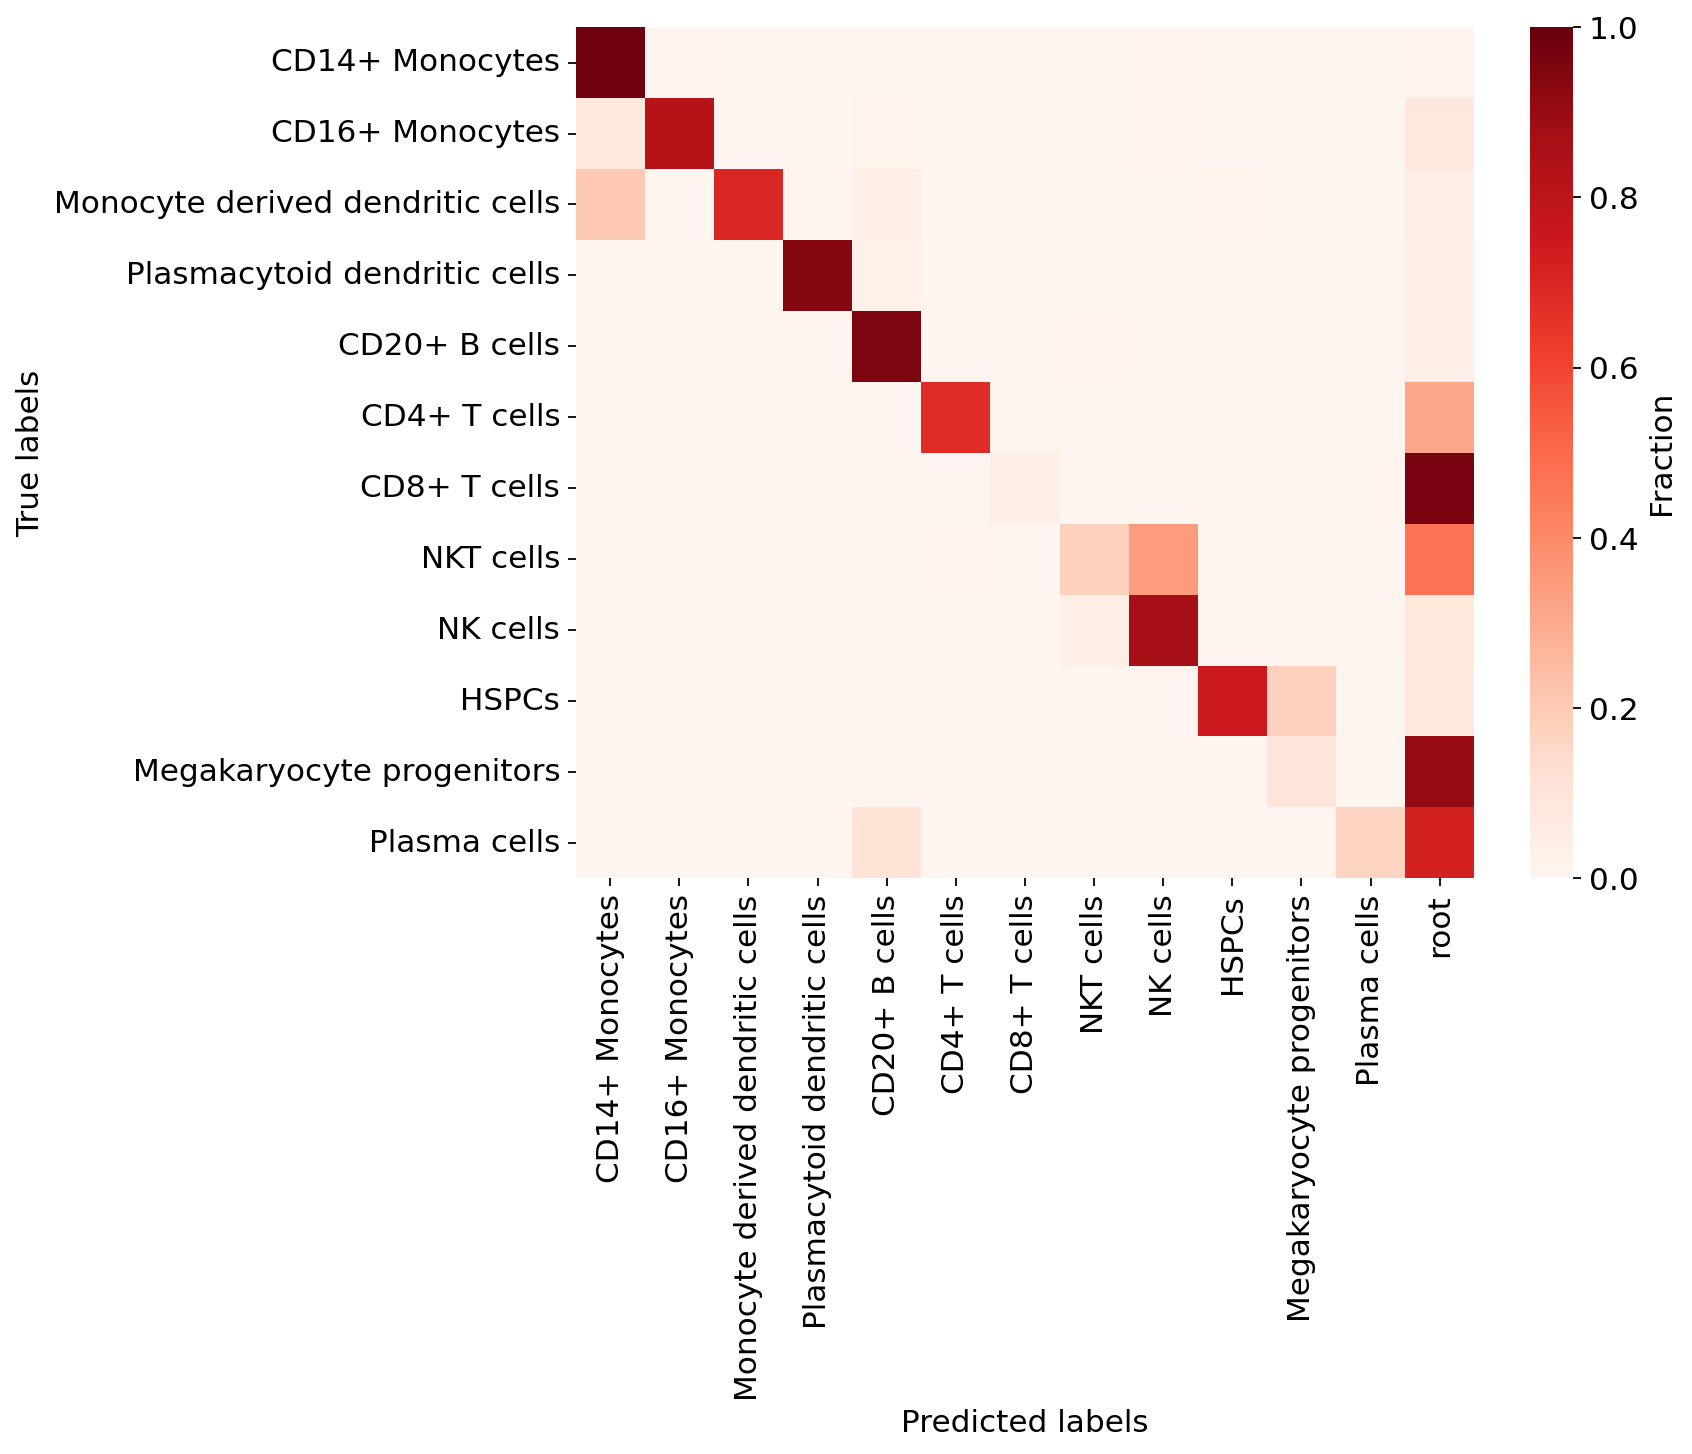

In [66]:
sca.classifiers.scHPL.evaluate.heatmap(y_true, y_pred_flat_svm,
                                      shape=(9,7), order_rows=order_rows,
                                      order_cols=order_cols2)
plt.show()

Compare to Azimuth

In [67]:
pred_az['predicted.celltype'][pred_az['predicted.celltype'] == 'Monocyte-derived dendritic cells'] =  'Monocyte derived dendritic cells'

/tmp/ipykernel_2775689/1716091909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_az['predicted.celltype'][pred_az['predicted.celltype'] == 'Monocyte-derived dendritic cells'] =  'Monocyte derived dendritic cells'


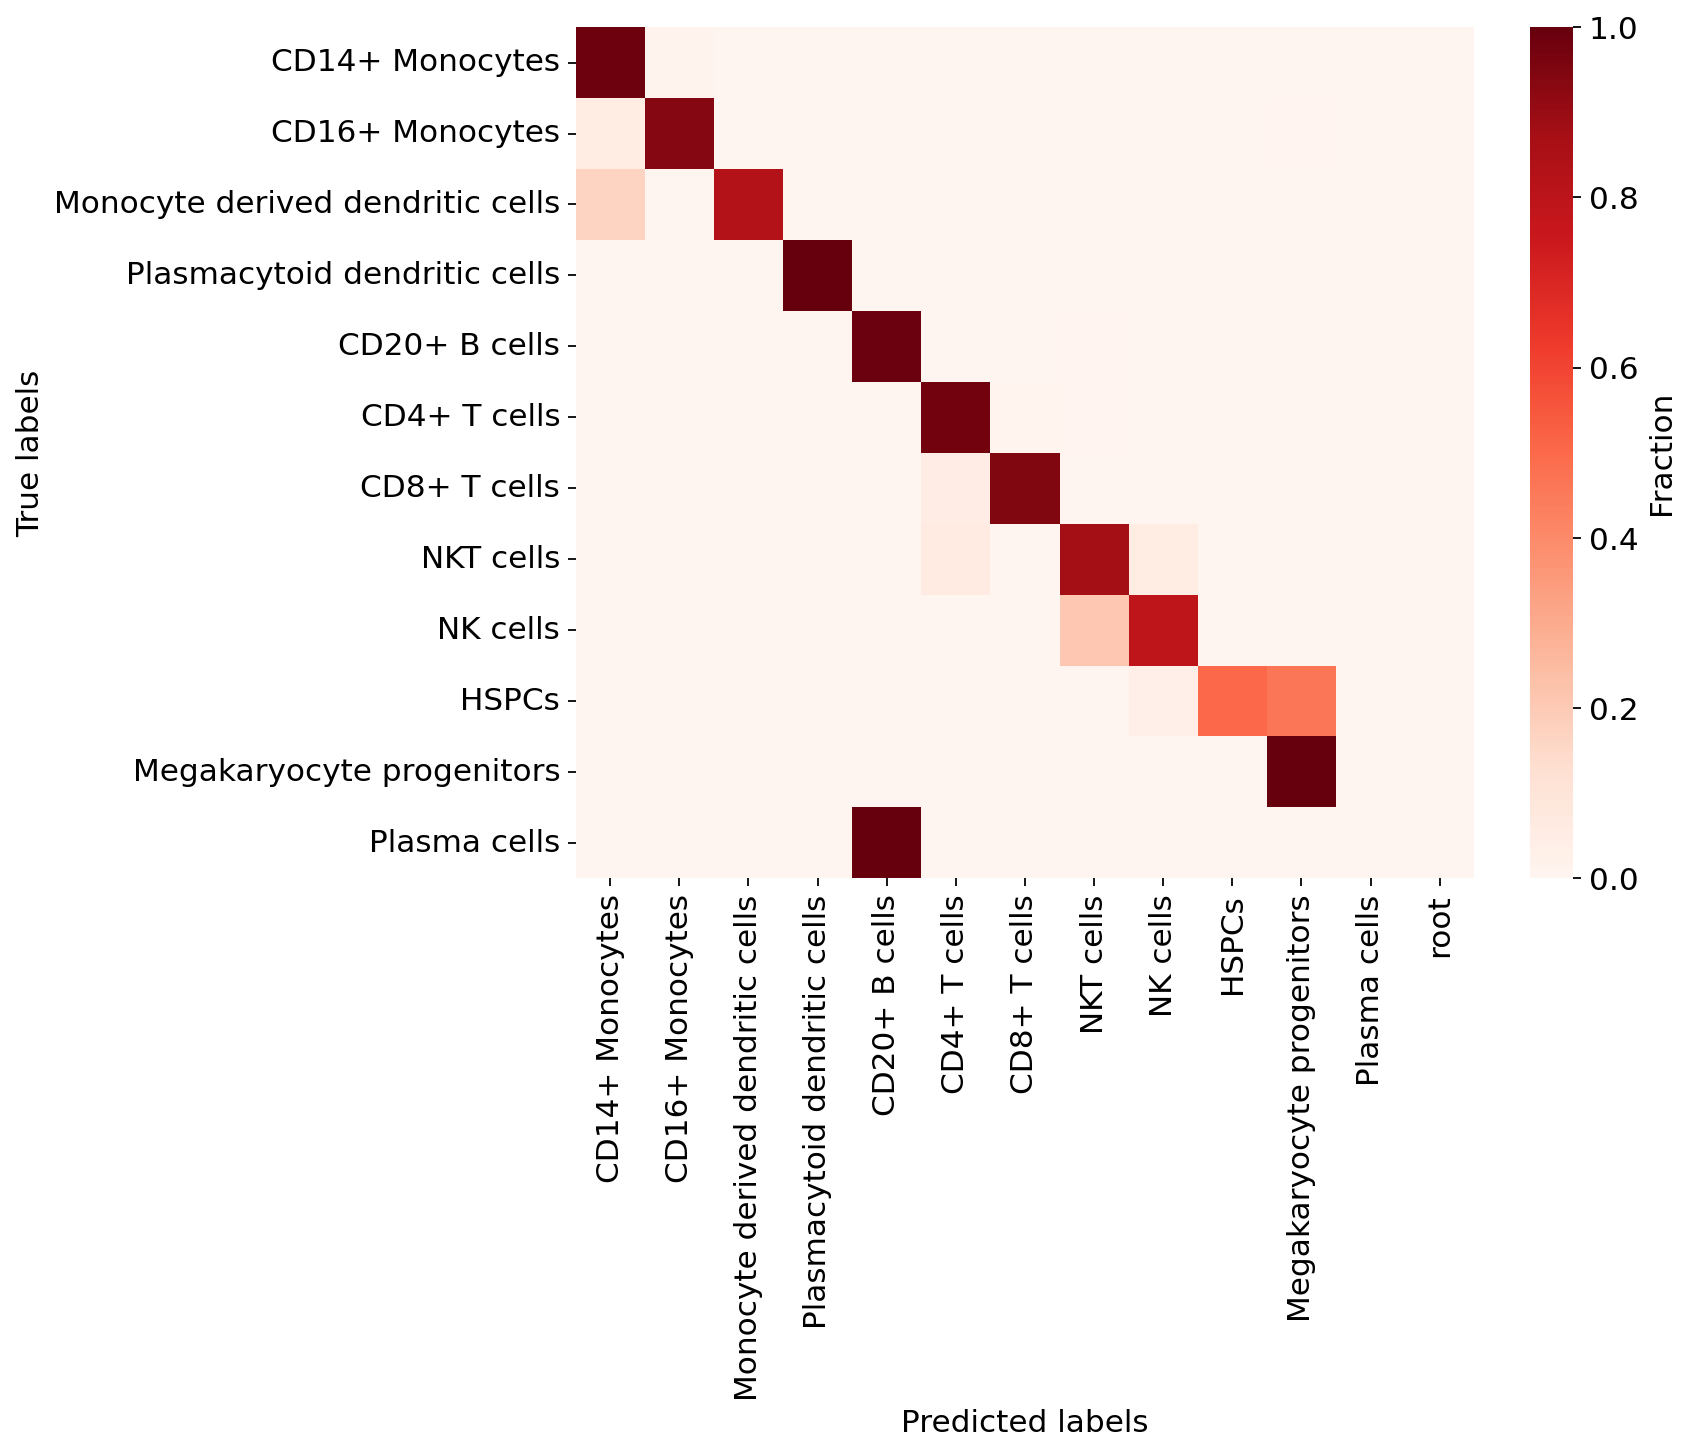

In [68]:
sca.classifiers.scHPL.evaluate.heatmap(y_true, pred_az['predicted.celltype'],
                                      shape=(9,7), order_rows=order_rows,
                                      order_cols=order_cols2)
plt.show()

In [69]:
F1_flat = pd.DataFrame(np.zeros((len(order_rows),3)), index=order_rows, columns=['treeArches (kNN)', 'Azimuth',
                                                                                'treeArches (linear SVM)'])

F1_flat['treeArches (kNN)'] = f1_score(y_true, y_pred_flat, average=None, labels=order_rows)
F1_flat['treeArches (linear SVM)'] = f1_score(y_true, y_pred_flat_svm, average=None, labels=order_rows)
F1_flat['Azimuth'] = f1_score(y_true, pred_az['predicted.celltype'], average=None, labels=order_rows)
F1_flat

treeArches (kNN)   Azimuth  \
CD14+ Monocytes                           0.986655  0.985396   
CD16+ Monocytes                           0.922636  0.916890   
Monocyte derived dendritic cells          0.848101  0.906907   
Plasmacytoid dendritic cells              0.981366  0.987805   
CD20+ B cells                             0.984928  0.989664   
CD4+ T cells                              0.967388  0.974941   
CD8+ T cells                              0.892809  0.927374   
NKT cells                                 0.463331  0.855427   
NK cells                                  0.816502  0.839298   
HSPCs                                     0.755556  0.666667   
Megakaryocyte progenitors                 0.000000  0.656250   
Plasma cells                              0.285714  0.000000   

                                  treeArches (linear SVM)  
CD14+ Monocytes                                  0.981271  
CD16+ Monocytes                                  0.883309  
Monocyte derived dendritic cells                 0.822006  
Plasmacytoid dendritic cells                     0.962025  
CD20+ B cells                                    0.970115  
CD4+ T cells                                     0.807124  
CD8+ T cells                                     0.076712  
NKT cells                                        0.290824  
NK cells                                         0.729294  
HSPCs                                            0.807692  
Megakaryocyte progenitors                        0.137931  
Plasma cells                                     0.285714

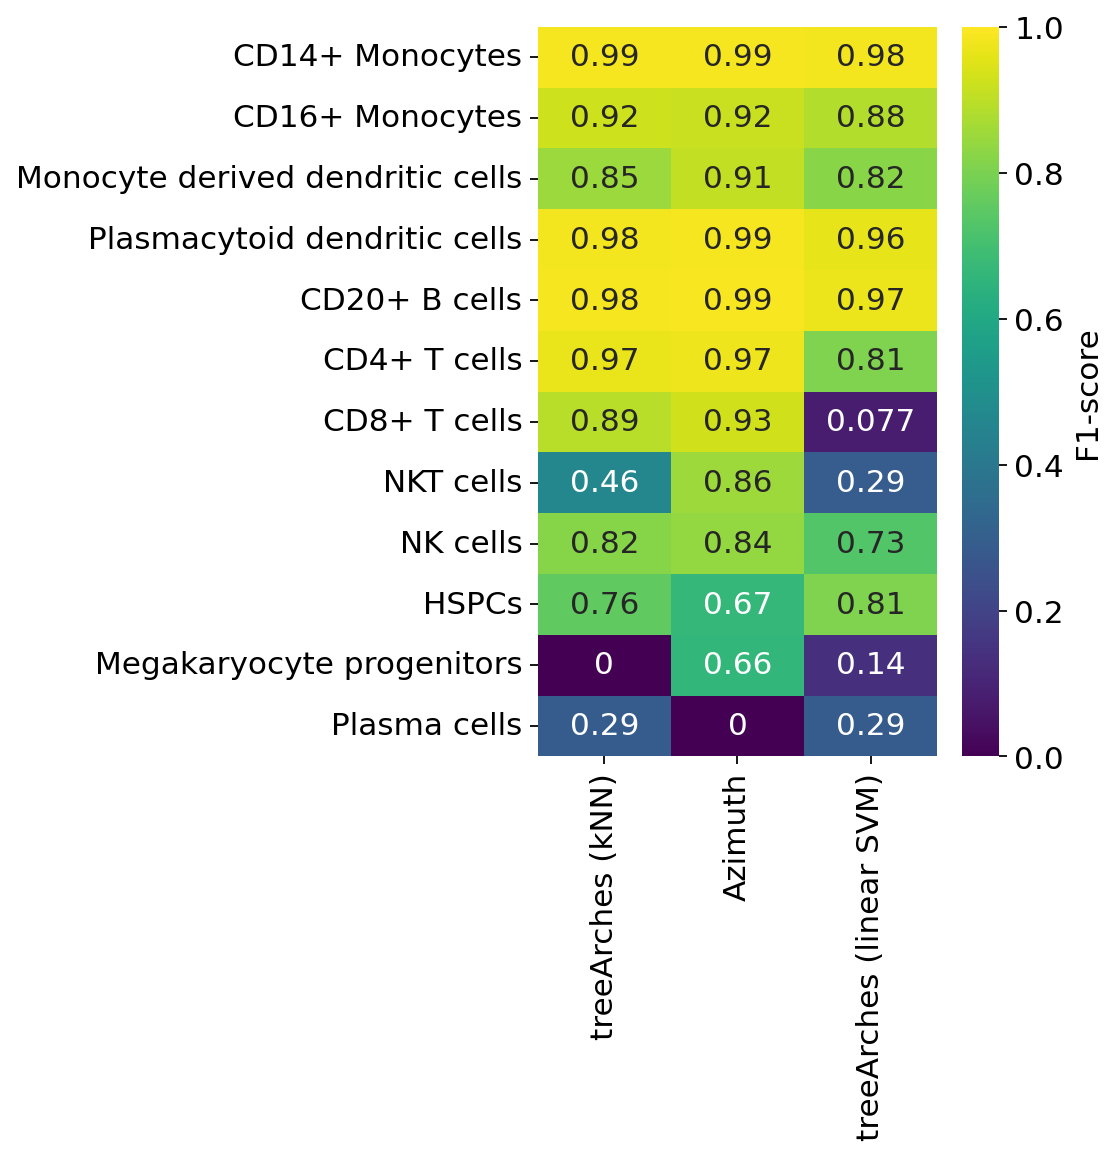

In [70]:
plt.figure(figsize=(4,6))
sns.heatmap(F1_flat,  vmin = 0, vmax = 1, 
                cbar_kws={'label': 'F1-score'}, cmap='viridis', annot=True)
plt.show()